In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns
import os
import json
from sklearn.decomposition import PCA
import umap.umap_ as umap
from itertools import permutations
np.random.seed(42)

%matplotlib inline  
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

In [2]:
# Set data input folder
# Download files described in README.md to this folder
input_folder = "inputs"

# Set output folder, subfolder
output_folder = "outputs"
if not os.path.exists(output_folder):
    os.makedirs(output_folder, exist_ok=True)
if not os.path.exists(os.path.join(output_folder,"figure_panels")):
    os.makedirs(os.path.join(output_folder,"figure_panels"), exist_ok=True)

In [3]:
# Import the HeLa DMEM gene-level profiles
df_gene_DMEM = pd.read_csv("../Profile_Aggregation/outputs/20210422_6W_CP257_guide_normalized_feature_select_median_merged_ALLBATCHES___DMEM___ALLWELLS_gene_aggregated.csv.gz").set_index('Metadata_Foci_Barcode_MatchedTo_GeneCode')
# Import the HeLa HPLM gene-level profiles
df_gene_HPLM = pd.read_csv("../Profile_Aggregation/outputs/20210422_6W_CP257_guide_normalized_feature_select_median_merged_ALLBATCHES___HPLM___ALLWELLS_gene_aggregated.csv.gz").set_index('Metadata_Foci_Barcode_MatchedTo_GeneCode')

# Import annotated gene sets
with open("../common_files/annotated_gene_sets.json") as f:
    gene_set_dict = json.load(f)

# Load p_values from the hit calling process
df_p_values_DMEM = pd.read_csv('../Hit_Calling/outputs/HeLa_DMEM_significant_features_mann_whitney_p_values.csv.gz')
df_p_values_DMEM = df_p_values_DMEM.set_index('Gene')
df_p_values_HPLM = pd.read_csv('../Hit_Calling/outputs/HeLa_HPLM_significant_features_mann_whitney_p_values.csv.gz')
df_p_values_HPLM = df_p_values_HPLM.set_index('Gene')

# Load expression data 
with open("../Hit_Calling/outputs/HeLa_CCLE_expression_summary.json") as f:
    express = json.load(f)
    zero_tpm_list = express['zero_tpm']
    expressed_gene_list = express['expressed_genes']

# Input the protein clusters from the CORUM and STRING databases
CORUM_data = pd.read_csv('../common_files/CORUM_humanComplexes.txt',sep = '\t')
STRING_data = pd.read_csv('../common_files/STRING_data.csv.gz')

# Input the protein clusters from the CORUM
ppi_data = pd.read_csv('../common_files/CORUM_humanComplexes.txt',sep = '\t')

# Figure 3A and 3B

In [10]:
# Extract the features from the guide level profiles
feature_dict = {}
for (df_p_value, condition) in [(df_p_values_DMEM, 'DMEM'), (df_p_values_HPLM, 'HPLM')]:
      features = list(df_p_value.columns)[2:]
      mito_list = [feature for feature in df_p_value.columns if 'mito'  in feature.lower()]
      cona_list = [feature for feature in df_p_value.columns if 'cona'  in feature.lower()]
      dapi_list = [feature for feature in df_p_value.columns if 'dapi'  in feature.lower()]
      wga_list = [feature for feature in df_p_value.columns if 'wga'  in feature.lower()]
      phalloidin_list = [feature for feature in df_p_value.columns if 'phalloidin'  in feature.lower()]
      feature_dict[condition] = {'Mito':mito_list,'ConA':cona_list,'DAPI':dapi_list,'WGA':wga_list,'Phalloidin':phalloidin_list,'Sum':features}
      print(f'Number of features per compartment, {condition}: ','\n',
            'Mito features: ',len(mito_list),'\n',
            'ConA features: ',len(cona_list),'\n',
            'DAPI features: ',len(dapi_list),'\n',
            'WGA features: ',len(wga_list),'\n',
            'Phalloidin features: ',len(phalloidin_list))

Number of features per compartment, DMEM:  
 Mito features:  376 
 ConA features:  223 
 DAPI features:  379 
 WGA features:  287 
 Phalloidin features:  220
Number of features per compartment, HPLM:  
 Mito features:  399 
 ConA features:  250 
 DAPI features:  370 
 WGA features:  337 
 Phalloidin features:  261


In [18]:
# Calculate false discovery rate (FDR)
def FDR_1(control_sig_feature):
    total = len(control_sig_feature)
    FDR_1 = int(total/100)
    mito_1, cona_1, wga_1, dapi_1, phal_1, sum_1 = 0,0,0,0,0,0
    channels = ['Mito','ConA','WGA','DAPI','Phalloidin']
    c = 200
    feat_1 = 0
    while feat_1 <= FDR_1:
        feat_1 = len(control_sig_feature.query('Mito > @c'))
        mito_1 = c + 1
        c-=1    
    
    c = 200
    feat_1 = 0
    while feat_1 <= FDR_1:
        feat_1 = len(control_sig_feature.query('ConA > @c'))
        cona_1 = c + 1
        c-=1     
        
    c = 200
    feat_1 = 0
    while feat_1 <= FDR_1:
        feat_1 = len(control_sig_feature.query('WGA > @c'))
        wga_1 = c + 1
        c-=1    
    
    c = 200
    feat_1 = 0
    while feat_1 <= FDR_1:
        feat_1 = len(control_sig_feature.query('DAPI > @c'))
        dapi_1 = c + 1
        c-=1    
    
    c = 200
    feat_1 = 0
    while feat_1 <= FDR_1:
        feat_1 = len(control_sig_feature.query('Phalloidin > @c'))
        phal_1 = c + 1
        c-=1    
        
    c = 500
    feat_1 = 0
    while feat_1 <= FDR_1:
        feat_1 = len(control_sig_feature.query('Sum > @c'))
        sum_1 = c + 1
        c-=1    
    
    return mito_1, cona_1, wga_1, dapi_1, phal_1, sum_1

In [26]:
# Quantification of number of significant features per compartment at a certain p-value
threshold_dict = {}
for (df_p_values, condition) in [(df_p_values_DMEM, 'DMEM'), (df_p_values_HPLM, 'HPLM')]:
    p_value = 0.001
    gene_list = list(df_p_values.index)

    df_sig_feature = pd.DataFrame(index=gene_list)
    for gene in gene_list:
        for channel in feature_dict[condition].keys():
            count = 0
            for feat in feature_dict[condition][channel]:
                if df_p_values.loc[gene,feat]<p_value:
                    count += 1
            df_sig_feature.loc[gene,channel] = count
        
    df_sig_feature = df_sig_feature.drop(index = 'sig_gene_count')
    # Perturbations divided into 2 groups of controls with 0 TPM and others
    df_sig_feature_zero_tpm = df_sig_feature.loc[zero_tpm_list]
    df_sig_feature_zero_tpm.reset_index().rename(columns={'index':'Gene'}).to_csv(os.path.join(output_folder,f'HeLa_{condition}_significant_features_0TPM_genes.csv'),index=False)
    df_sig_feature_expressed = df_sig_feature.loc[expressed_gene_list]
    df_sig_feature_expressed.reset_index().rename(columns={'index':'Gene'}).to_csv(os.path.join(output_folder,f'HeLa_{condition}_significant_features_expressed_genes.csv'),index=False)

    # Compute and print the threshold for FDR calculations at 5% from the 0 TPM gene perturbations
    mito_1, cona_1, wga_1, dapi_1, phal_1,sum_1 = FDR_1(df_sig_feature_zero_tpm)
    threshold_dict[condition] = {'Mito':mito_1, 'ConA':cona_1, 'WGA':wga_1, 'DAPI':dapi_1, 'Phalloidin':phal_1,'Sum':sum_1}
    print(f'For HeLa {condition} \n'
        'Mito genes', mito_1, '\n', 
        'ConA genes', cona_1, '\n', 
        'WGA genes', wga_1, '\n', 
        'DAPI genes', dapi_1, '\n', 
        'Phalloidin genes', phal_1, '\n',
        'Whole Profile genes', sum_1)
    
    df = df_sig_feature_expressed.copy()
    whole_cell_hits = df.query('Sum > @sum_1')
    comp_spec_hits = df.query('Sum <= @sum_1').query('Phalloidin > @phal_1 | DAPI > @dapi_1 | WGA > @wga_1 | ConA > @cona_1 | Mito > @mito_1')
    whole_cell_hits.reset_index().rename(columns={'index':'Gene'}).to_csv(os.path.join(output_folder,f'HeLa_{condition}_plate_level_median_per_feat_sig_genes_1_FDR_whole_cell_hits.csv'),index=False)
    comp_spec_hits.reset_index().rename(columns={'index':'Gene'}).to_csv(os.path.join(output_folder,f'HeLa_{condition}_plate_level_median_per_feat_sig_genes_1_FDR_compartment_specific_hits.csv'),index=False)


For HeLa DMEM 
Mito genes 64 
 ConA genes 52 
 WGA genes 72 
 DAPI genes 60 
 Phalloidin genes 61 
 Whole Profile genes 221
For HeLa HPLM 
Mito genes 101 
 ConA genes 72 
 WGA genes 117 
 DAPI genes 82 
 Phalloidin genes 74 
 Whole Profile genes 347


In [20]:
# Load outputs from previous cell
df_sig_feature_expressed_DMEM = pd.read_csv(os.path.join(output_folder,f'HeLa_DMEM_significant_features_expressed_genes.csv')).set_index('Gene')
df_sig_feature_expressed_HPLM = pd.read_csv(os.path.join(output_folder,f'HeLa_HPLM_significant_features_expressed_genes.csv')).set_index('Gene')
whole_cell_hits_DMEM = pd.read_csv(os.path.join(output_folder,f'HeLa_DMEM_plate_level_median_per_feat_sig_genes_1_FDR_whole_cell_hits.csv')).set_index('Gene')
whole_cell_hits_HPLM = pd.read_csv(os.path.join(output_folder,f'HeLa_HPLM_plate_level_median_per_feat_sig_genes_1_FDR_whole_cell_hits.csv')).set_index('Gene')
comp_spec_hits_DMEM = pd.read_csv(os.path.join(output_folder,f'HeLa_DMEM_plate_level_median_per_feat_sig_genes_1_FDR_compartment_specific_hits.csv')).set_index('Gene')
comp_spec_hits_HPLM = pd.read_csv(os.path.join(output_folder,f'HeLa_HPLM_plate_level_median_per_feat_sig_genes_1_FDR_compartment_specific_hits.csv')).set_index('Gene')


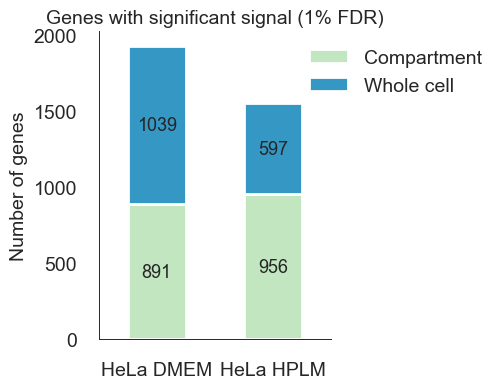

In [7]:
# Plot hits summary for Fig 3A
mpl.rc('axes', linewidth=0.7)
mpl.rc('xtick', labelsize=14)
mpl.rc('xtick', labelsize=14)

fig, ax = plt.subplots(figsize=(3,4))
colors = sns.color_palette('GnBu')[:8]
hits_plot = pd.DataFrame({'Compartment': [len(comp_spec_hits_DMEM), len(comp_spec_hits_HPLM)],
                         'Whole cell': [len(whole_cell_hits_DMEM),len(whole_cell_hits_HPLM)]},
                        index=['HeLa DMEM','HeLa HPLM'])

hits_plot.plot(kind='bar', 
               stacked=True,
               color=[colors[1], colors[4]],
               legend = 'reverse',
               rot = 0,
               fontsize= 14,
               width = 0.5,
               ax=ax)

ax.set_title('Genes with significant signal (1% FDR)',size=14) #Genes with significant signal above noise
ax.set_ylabel('Number of genes',size=14)

ax.bar_label(ax.containers[0],label_type='center',size=13)
ax.bar_label(ax.containers[1],label_type='center',size=13)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc="upper left", bbox_to_anchor=(0.83,1),frameon=False, ncol=1, fontsize =14)
fig.savefig(os.path.join(output_folder,'figure_panels','Fig3A_HeLa_DMEM_HPLM_whole_cell_compartment_specific_hits.png'),dpi = 300,bbox_inches='tight')

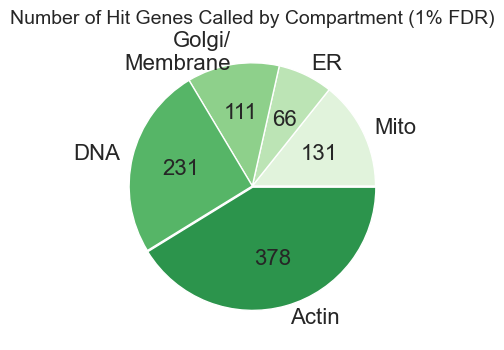

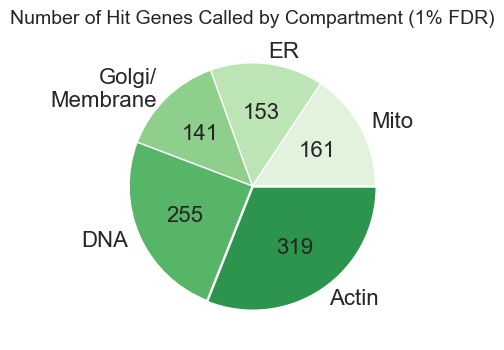

In [8]:
# Plot hits summary for Fig 3B
def absolute_value2(val):
    a  = data[np.abs(data - val/100.*sum(data)).argmin() ]
    return a

for (df, condition) in [(comp_spec_hits_DMEM,'DMEM'),(comp_spec_hits_HPLM,'HPLM')]:
        labels = ['Mito','ER','Golgi/\nMembrane','DNA','Actin']
        mito_1 = threshold_dict[condition]['Mito']
        cona_1 = threshold_dict[condition]['ConA']
        wga_1 = threshold_dict[condition]['WGA']
        dapi_1 = threshold_dict[condition]['DAPI']
        phal_1 = threshold_dict[condition]['Phalloidin']
        data = [len(df.query('Mito > @mito_1 & Sum <= @sum_1')),
                len(df.query('ConA > @cona_1 & Sum <= @sum_1')),
                len(df.query('WGA > @wga_1 & Sum <= @sum_1')),
                len(df.query('DAPI > @dapi_1 & Sum <= @sum_1')),
                len(df.query('Phalloidin > @phal_1 & Sum <= @sum_1'))]
        colors = sns.color_palette('Greens')[:5]    
        fig, ax = plt.subplots(figsize=(7,4))

        sns.set_theme(style='white',palette='RdBu')
        plt.pie(data,
                labels=labels,
                autopct=absolute_value2,
                colors=colors,
                textprops={'fontsize': 16},
                explode=(0.0, 0.0, 0.0, 0.0, 0.01))
        ax.set_title('Number of Hit Genes Called by Compartment (1% FDR)',size=14)
        fig.savefig(os.path.join(output_folder,'figure_panels',f'Fig3B_HeLa_{condition}_compartment_specific_hits_distribution.png'),dpi = 300,bbox_inches='tight')

# Figure 3C

In [9]:
# Directly load hit lists to bypass running Figure 3A/B
#whole_cell_hits_DMEM = pd.read_csv(os.path.join(output_folder,'HeLa_DMEM_plate_level_median_per_feat_sig_genes_1_FDR_whole_cell_hits.csv')).set_index('Gene')
#comp_spec_hits_DMEM = pd.read_csv(os.path.join(output_folder,'HeLa_DMEM_plate_level_median_per_feat_sig_genes_1_FDR_compartment_specific_hits.csv')).set_index('Gene')
#whole_cell_hits_HPLM = pd.read_csv(os.path.join(output_folder,'HeLa_DMEM_plate_level_median_per_feat_sig_genes_1_FDR_whole_cell_hits.csv')).set_index('Gene')
#comp_spec_hits_HPLM = pd.read_csv(os.path.join(output_folder,'HeLa_DMEM_plate_level_median_per_feat_sig_genes_1_FDR_compartment_specific_hits.csv')).set_index('Gene')

In [10]:
hit_list_DMEM = list(comp_spec_hits_DMEM.index) + list(whole_cell_hits_DMEM.index)
df_hits_DMEM = df_gene_DMEM.loc[df_gene_DMEM.index.isin(hit_list_DMEM)]
hit_list_HPLM = list(comp_spec_hits_HPLM.index) + list(whole_cell_hits_HPLM.index)
df_hits_HPLM = df_gene_HPLM.loc[df_gene_HPLM.index.isin(hit_list_HPLM)]

# Perform principal component analysis on hit lists
df_hits_pca_dict = {}
for (df_hits, condition) in [(df_hits_DMEM, 'DMEM'), (df_hits_HPLM, 'HPLM')]:
    pca = PCA()
    pca.fit(df_hits)
    x = list(pca.explained_variance_ratio_)
    # Find principal component that represents 90% variation
    PCA_lookup = {}
    for i in range(len(x)):
        distance = abs(.9-sum(x[:i+1]))
        PCA_lookup[distance] = i 
    component = PCA_lookup[min(PCA_lookup.keys())]+1
    print (f'For {condition}, principal component representing closest to 90% variation is {component}')
    # Perform principal component analysis and select components representing 70% of variation in data
    pca = PCA(n_components=component)
    df_hits_pca = pd.DataFrame(pca.fit_transform(df_hits),index=df_hits.index)
    df_hits_pca_dict[condition] = df_hits_pca
    df_hits_pca.head()
    df_hits_pca.to_csv(os.path.join(output_folder,f'HeLa_{condition}_hit_list_PCA.csv'))

For DMEM, principal component representing closest to 90% variation is 325
For HPLM, principal component representing closest to 90% variation is 231


Overall number of paired correlations for DMEM is 1861485
For condition DMEM 
 hit set is 877, cluster count is 1350, hit cluster list is 1350
For condition DMEM 
 Number of hit pairs is 3940 
 Number of hit pairs with correlation is 3940


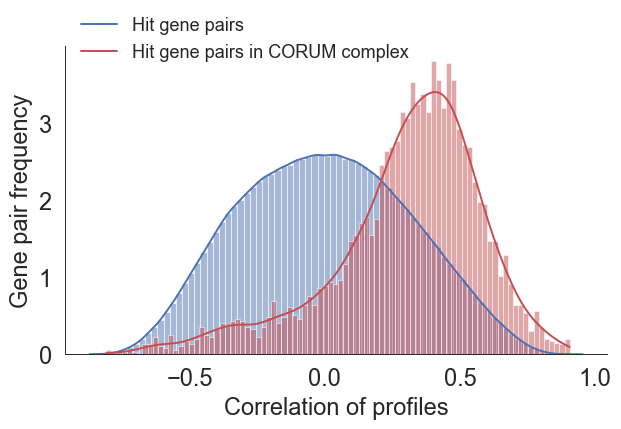

Overall number of paired correlations for HPLM is 1205128
For condition HPLM 
 hit set is 671, cluster count is 953, hit cluster list is 953
For condition HPLM 
 Number of hit pairs is 1341 
 Number of hit pairs with correlation is 1340


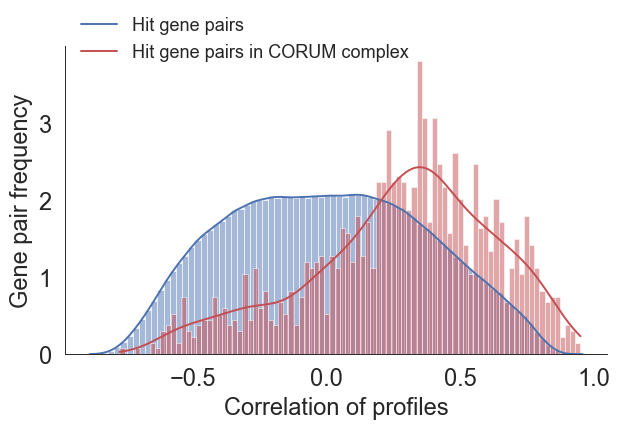

In [11]:
# Calculate correlation between all gene pairs and create a dictionary of gene pairs/correlation
parent_corr_dic = {}
for (df_hits, condition) in [(df_hits_pca_dict['DMEM'], 'DMEM'), (df_hits_pca_dict['HPLM'], 'HPLM')]:
    df_hits_corr = df_hits.T.corr()
    genes = list(df_hits_corr.index)
    corr_dic = {}
    for gene1 in genes:
        for gene2 in genes:
            if len(frozenset([gene1,gene2])) == 1 :
                continue
            else:    
                corr_dic[frozenset([gene1,gene2])]=(df_hits_corr.loc[gene1,gene2])
    parent_corr_dic[condition] = corr_dic
    print (f'Overall number of paired correlations for {condition} is {len(corr_dic)}')

    # Create a list of protein clusters with all complexes that had at least 66% of genes represented within the hits
    cluster_count = 0
    hit_cluster_list_list = []
    hit_set = set()
    for i in range(len(ppi_data)):
        cluster = ppi_data.iloc[i]['subunits(Gene name)'].split(';')
        count = 0
        hit_cluster_list = []
        for g in cluster:
            if g in genes:
                count += 1
                hit_set.add(g)
                hit_cluster_list.append(g)
        if (count/len(cluster)) > 0.333:
            cluster_count += 1
        if hit_cluster_list and (count/len(cluster)) > 0.333:
            hit_cluster_list_list.append(hit_cluster_list)
    print(f'For condition {condition} \n hit set is {len(hit_set)}, cluster count is {cluster_count}, hit cluster list is {len(hit_cluster_list_list)}')

    # Assign correlations to hit gene pairs
    hit_pair_set = set()
    for l in hit_cluster_list_list:
        for c in list(permutations(l,2)):
            hit_pair_set.add(frozenset(c))

    hit_corr_dic = {}
    for s in hit_pair_set:
        if len(s) != 1:
            hit_corr_dic[s] = corr_dic[s]

    print(f'For condition {condition} \n Number of hit pairs is {len(hit_pair_set)} \n',
        f'Number of hit pairs with correlation is {len(hit_corr_dic)}')
    
    # Plot CORUM gene pair correlation distribution for Fig 3C
    sns.set_theme(style="white",rc = {'axes.linewidth': 0.7,'xtick.labelsize':17,'ytick.labelsize':17})
    fig, ax = plt.subplots(figsize=(7,4))
    all_corr = list(corr_dic.values())
    cluster_corr = list(hit_corr_dic.values())

    sns.histplot(all_corr ,color='b' ,stat= 'percent' ,bins= 80, kde=True, line_kws={'lw':1.4} , alpha=0.5,ax = ax);
    sns.histplot(cluster_corr ,color='r' ,stat= 'percent' ,bins= 90, kde=True, line_kws={'lw':1.4} ,alpha=0.5,ax = ax);

    ax.set_ylabel('Gene pair frequency',size=17)
    ax.set_xlabel('Correlation of profiles',size=17)
    font = font_manager.FontProperties(size=13)
    ax.legend(['Hit gene pairs','Hit gene pairs in CORUM complex'],loc='upper left',bbox_to_anchor=(0.0,1.15),frameon=False,prop=font )
    sns.despine(top = True)

    fig.savefig(os.path.join(output_folder,'figure_panels',f'Fig3C_HeLa_{condition}_CORUM_gene_pair_correlation_distribution.png'), dpi=300,facecolor='w', edgecolor='w', bbox_inches='tight')
    plt.show()

# Figure 3D

Minimum correlation for DMEM is -0.8694034022377277
Maximum correlation for DMEM is 0.9541995650483851


/var/folders/pm/r5xv70_14yx_b9gflxr4xck40000gp/T/ipykernel_19551/1552904741.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(round(float(label))) for label in labels], size=16)


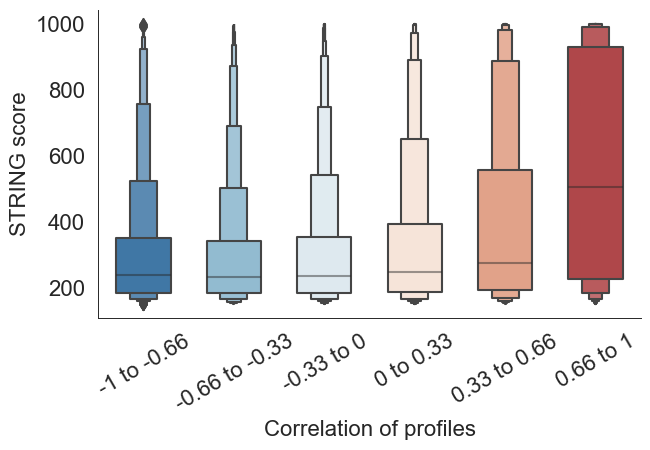

Minimum correlation for HPLM is -0.8887593645857368
Maximum correlation for HPLM is 0.9581563617877422


/var/folders/pm/r5xv70_14yx_b9gflxr4xck40000gp/T/ipykernel_19551/1552904741.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(round(float(label))) for label in labels], size=16)


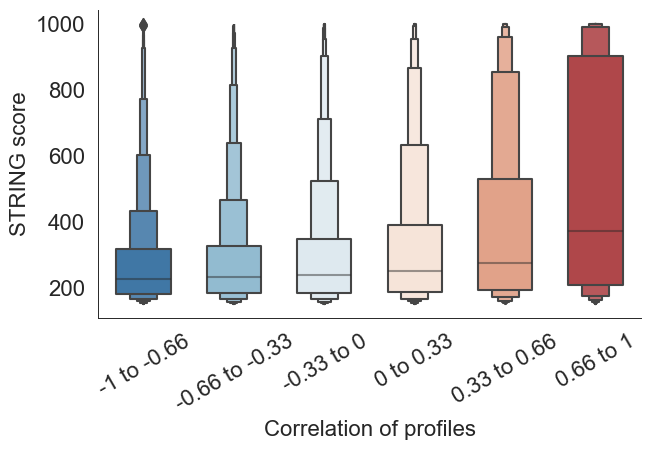

In [12]:
for (df_hits, condition) in [(df_hits_DMEM, 'DMEM'), (df_hits_HPLM, 'HPLM')]:
    # Subset the STRING predicted protein links to HeLa WGS hits
    genes = list(df_hits.index)
    ppi_data_name_hits = STRING_data[STRING_data['protein1'].isin(genes) & STRING_data['protein2'].isin(genes)]

    # Determine min, max
    print(f'Minimum correlation for {condition} is {min(parent_corr_dic[condition].values())}')
    print(f'Maximum correlation for {condition} is {max(parent_corr_dic[condition].values())}')

    # Bin the correlations into 8 categories 
    results = ppi_data_name_hits.copy(deep=True).reset_index(drop=True)

    bins = [-1,-0.66,-0.33,0,0.33,0.66,1]
    for i in range(len(results)):
        gene1 = results.iloc[i]['protein1']
        gene2 = results.iloc[i]['protein2']
        corr_value = parent_corr_dic[condition][frozenset([gene1,gene2])]
        results.at[i , 'correlation'] = corr_value
        if corr_value > bins[5]:
            results.at[i , 'correlation_bin'] = f'{bins[5]} to {bins[6]}'
        elif corr_value > bins[4] and corr_value <= bins[5]:
            results.at[i , 'correlation_bin'] = f'{bins[4]} to {bins[5]}'
        elif corr_value > bins[3] and corr_value <= bins[4]:
            results.at[i , 'correlation_bin'] = f'{bins[3]} to {bins[4]}'
        elif corr_value > bins[2] and corr_value <= bins[3]:
            results.at[i , 'correlation_bin'] = f'{bins[2]} to {bins[3]}'
        elif corr_value > bins[1] and corr_value <= bins[2]:
            results.at[i , 'correlation_bin'] = f'{bins[1]} to {bins[2]}'
        elif corr_value <= bins[1]:
            results.at[i , 'correlation_bin'] = f'{bins[0]} to {bins[1]}'
    
    # Plot STRING score X gene pair correlation for Fig 3D
    sns.set_theme(style="white",rc = {'axes.linewidth': 0.7})

    fig, ax = plt.subplots(figsize=(7,4))
    order = [f'{bins[0]} to {bins[1]}',f'{bins[1]} to {bins[2]}',f'{bins[2]} to {bins[3]}',f'{bins[3]} to {bins[4]}',f'{bins[4]} to {bins[5]}',f'{bins[5]} to {bins[6]}']

    flierprops = dict(markerfacecolor='white', markersize=0.1, linestyle='none')
    sns.boxenplot(data=results,
                x = 'correlation_bin',
                y = 'combined_score', 
                order=order, 
                width = 0.6,
                palette = 'RdBu_r',
                ax=ax)

    ax.set_xlabel('Correlation of profiles',size=16)
    ax.set_ylabel('STRING score',size=16)
    ax.tick_params(axis='both', which='major', labelsize=14)

    labels = [item for item in ax.get_yticks()]
    ax.set_yticklabels([str(round(float(label))) for label in labels], size=16)
    ax.set_xticklabels(order, size=16,rotation=30)

    sns.despine(top = True,left=False,bottom=False)

    fig.savefig(os.path.join(output_folder,'figure_panels',f'Fig3D_HeLa_{condition}_STRING_gene_pair_correlation_score.png'), 
                dpi=300,
                facecolor='w', 
                edgecolor='w', 
                bbox_inches='tight')
    plt.show()

# Figures 3E and 3F

For DMEM label length is 891
For HPLM label length is 956


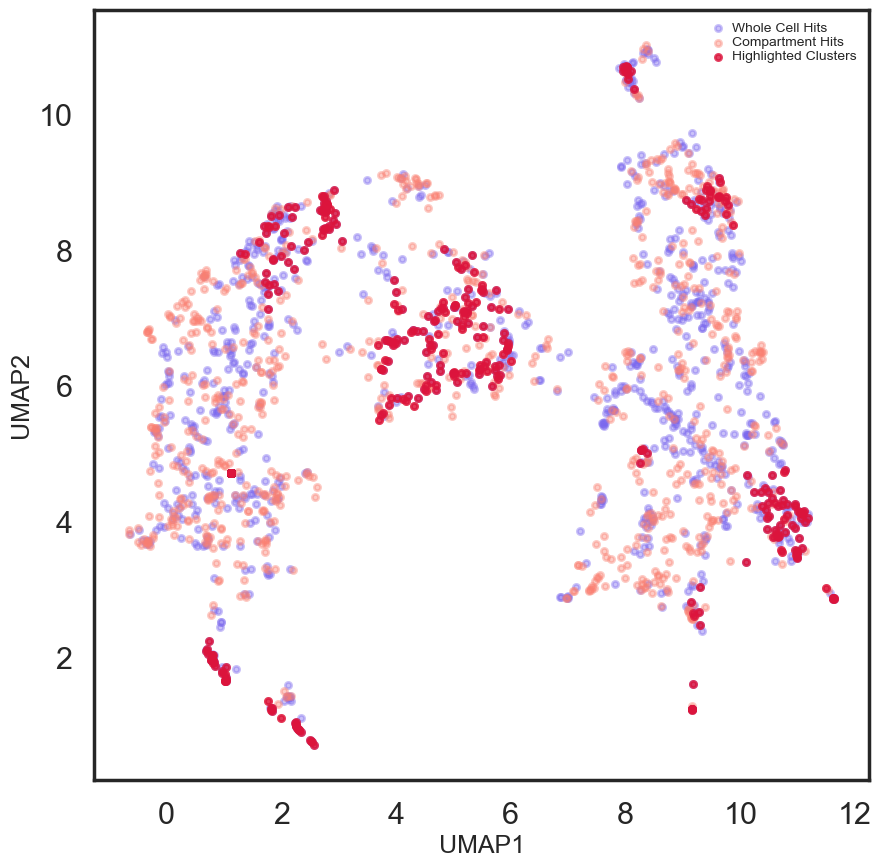

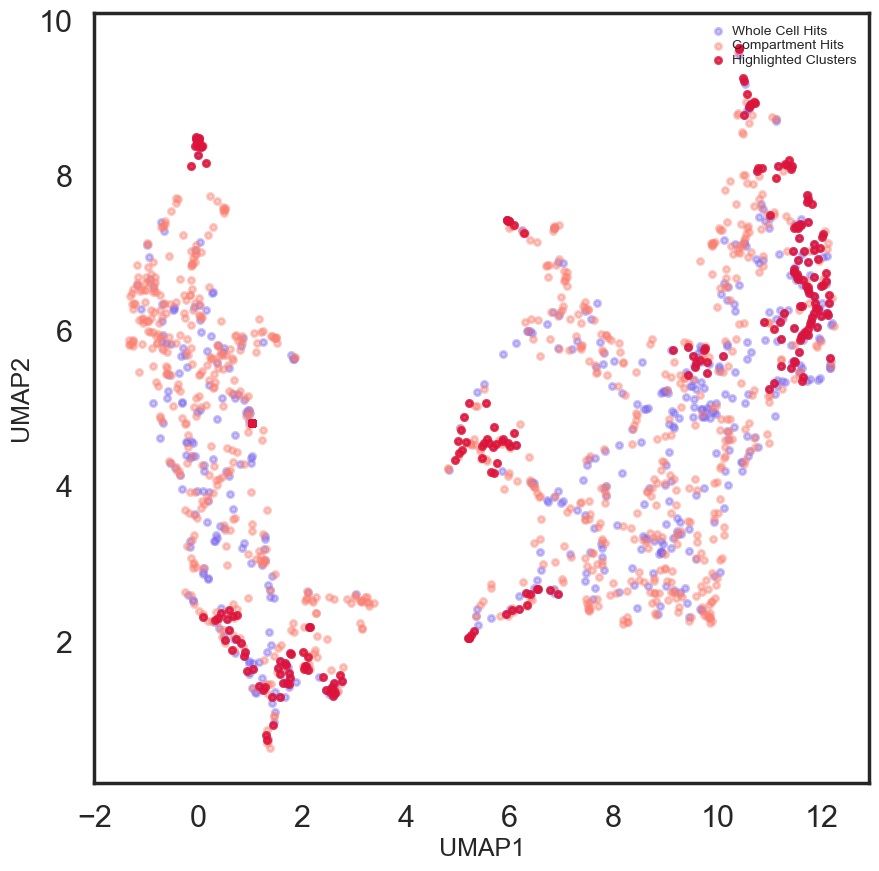

In [31]:
for (df_hits_pca, whole_cell_hits, hit_list, condition) in [(df_hits_pca_dict['DMEM'], whole_cell_hits_DMEM, hit_list_DMEM,'DMEM'), (df_hits_pca_dict['HPLM'],  whole_cell_hits_HPLM, hit_list_HPLM,'HPLM')]:
    # Perform UMAP dimensionality reduction
    clusterable_embedding = umap.UMAP(
        n_neighbors=4,
        min_dist=0.04,
        n_components=2,
        random_state=43,
        metric = 'cosine',
    ).fit_transform(df_hits_pca)

    # Manually label highlighted hits  
    overall_labels = [list(df_hits_pca.index).index(i) if i in list(whole_cell_hits.index) else -1 for i in hit_list]
    other_labels = [list(df_hits_pca.index).index(i) if i not in list(whole_cell_hits.index) else -1 for i in hit_list]
    
    if condition == 'DMEM':
        highlight_categories = ['MITOCHONDRIAL_MATRIX','DNA_REPLICATION','RIBOSOME_BIOGENESIS','MANNOSYLATION','PROTON_TRANSPORTING_TWO_SECTOR_ATPASE_COMPLEX','GOLGI_VESICLE_TRANSPORT','ARP2_3_COMPLEX_MEDIATED_ACTIN_NUCLEATION','PROTEIN_N_LINKED_GLYCOSYLATION','PROTEIN_TARGETING_TO_MITOCHONDRION','NUCLEOPLASM','PROTEIN_BINDING']
        highlight_list = []
        for x in highlight_categories:
            highlight_list += gene_set_dict[f"{x}_DMEM_CLUSTER"]
    if condition == 'HPLM':
        highlight_categories = ['GOLGI_MEMBRANE','PROTEIN_N_LINKED_GLYCOSYLATION','DNA_REPLICATION','RIBOSOME_BIOGENESIS','PROTON_TRANSPORTING_TWO_SECTOR_ATPASE_COMPLEX','LAMELLIPODIUM','AEROBIC_RESPIRATION','TRANSFERASE_COMPLEX','MITOCHONDRIAL_MATRIX','PROTEIN_TARGETING_TO_MITOCHONDRION']
        highlight_list = []
        for x in highlight_categories:
            highlight_list += gene_set_dict[f"{x}_HPLM_CLUSTER"]
    highlight_labels = [list(df_hits_pca.index).index(i) if i in highlight_list else -1 for i in hit_list]
    print (f'For {condition} label length is {len(overall_labels)-other_labels.count(-1)}')
    
    '''
    # Save the coordinates/additional information from the UMAP
    # Activate/Uncomment this section if you wish to freeze the UMAP version
    clusterable_embedding_x, clusterable_embedding_y = np.split(clusterable_embedding,2,axis=1)
    clusterable_embedding_x_list = clusterable_embedding_x.tolist()
    clusterable_embedding_y_list = clusterable_embedding_y.tolist()
    umap_dic = {
        f'{condition}_overall_labels':(overall_labels),
        f'{condition}_other_labels':(other_labels),
        f'{condition}_highlight_labels':(highlight_labels),
        f'{condition}_clusterable_embedding_x':(clusterable_embedding_x_list),
        f'{condition}_clusterable_embedding_y':(clusterable_embedding_y_list),
        f'{condition}_gene_names':(list(df_hits_pca.index))
    }
    umap_json = json.dumps(umap_dic)

    with open(os.path.join(output_folder,f"HeLa_{condition}_umap_frozen_version.json", "w")) as f:
        f.write(umap_json)
    '''
    
    # Load the frozen version of the UMAP data from the figure 
    # Deactivate/comment out this section if you wish to redraw the UMAP
    with open(os.path.join(output_folder,f"HeLa_{condition}_umap_frozen_version.json")) as f:
        umap_json = json.load(f)

    clusterable_embedding_x_list = umap_json[f'{condition}_clusterable_embedding_x']
    clusterable_embedding_y_list = umap_json[f'{condition}_clusterable_embedding_y']
    clusterable_embedding_x = np.asanyarray(clusterable_embedding_x_list,dtype='float32')
    clusterable_embedding_y = np.asanyarray(clusterable_embedding_y_list,dtype='float32')
    clusterable_embedding = np.column_stack((clusterable_embedding_x, clusterable_embedding_y))
    overall_labels = umap_json[f'{condition}_overall_labels']
    other_labels = umap_json[f'{condition}_other_labels']
    highlight_labels = umap_json[f'{condition}_highlight_labels']
    gene_names_with_order = umap_json[f'{condition}_gene_names']

    # Plot the data and color code based on the type of hit.
    plt.figure(figsize=(10, 10))
    plt.scatter(clusterable_embedding[overall_labels, 0],
                clusterable_embedding[overall_labels, 1],
                c='mediumslateblue',
                s=20,
                alpha=0.4,
            );
    plt.scatter(clusterable_embedding[other_labels, 0],
                clusterable_embedding[other_labels, 1],
                c='salmon',
                s=20,
                alpha=0.4,
            );
    plt.scatter(clusterable_embedding[highlight_labels, 0],
                clusterable_embedding[highlight_labels, 1],
                c='crimson',
                s=20,
                alpha=0.8,
            );
    plt.xlabel('UMAP1',fontsize=18)
    plt.ylabel('UMAP2',fontsize=18)
    plt.legend(labels=['Whole Cell Hits','Compartment Hits','Highlighted Clusters'],loc="upper right",bbox_to_anchor=(1,1), frameon=False, ncol=1,fontsize=10 ,labelspacing=0.1,handletextpad=0)# 

    plt.savefig(os.path.join(output_folder,'figure_panels',f'Fig3EF_HeLa_{condition}_UMAP_clustering.png'),bbox_inches='tight', dpi=600,facecolor='w', edgecolor='w')

# Figures 3H and 3I

In [14]:
# Perform principal component analysis on gene aggregated profiles
df_gene_pca_dict = {}
for (df_gene, condition) in [(df_gene_DMEM, 'DMEM'), (df_gene_HPLM, 'HPLM')]:
    pca = PCA()
    pca.fit(df_gene)
    x = list(pca.explained_variance_ratio_)
    # Find principal component that represents 70% variation
    PCA_lookup = {}
    for i in range(len(x)):
        distance = abs(.7-sum(x[:i+1]))
        PCA_lookup[distance] = i 
    component = PCA_lookup[min(PCA_lookup.keys())]+1
    print (f'For {condition}, principal component representing closest to 70% variation is {component}')
    # Perform principal component analysis and select components representing 70% of variation in data
    pca = PCA(n_components=component)
    df_gene_pca = pd.DataFrame(pca.fit_transform(df_gene),index=df_gene.index).reset_index().set_index('Metadata_Foci_Barcode_MatchedTo_GeneCode')
    df_gene_pca.to_csv(os.path.join(output_folder,f"HeLa_{condition}_PCA_gene_level_profiles.csv.gz"))
    df_gene_pca_dict[condition] = df_gene_pca
df_gene_pca.head()

For DMEM, principal component representing closest to 70% variation is 215
For HPLM, principal component representing closest to 70% variation is 160


,0,1,2,3,4,5,6,7,8,9,...,150,151,152,153,154,155,156,157,158,159
Metadata_Foci_Barcode_MatchedTo_GeneCode,,,,,,,,,,,,,,,,,,,,,
A1BG,1.631312,1.613159,3.014042,-1.749491,0.747655,-2.263314,1.621407,0.580308,0.266791,-1.611416,...,-0.255726,-0.122846,0.343823,0.730398,0.256137,-0.048790,-0.081431,-0.534355,0.223124,-0.073124
A1CF,2.979367,3.591269,-0.149918,-1.388088,0.091967,0.088882,-0.042084,0.026289,0.206233,-0.620842,...,-0.205287,0.158534,-0.273519,0.046426,-0.152456,-0.119154,0.255750,-0.008423,-0.024413,0.147007
A2M,1.769034,-1.775785,-1.059892,-4.576765,-0.036606,2.896833,1.086686,-0.909597,-1.201923,-0.162276,...,-0.231993,0.071327,0.072983,0.175225,0.439501,0.036267,0.169373,0.170937,-0.114842,0.037010
A2ML1,-0.131835,-1.229280,3.069760,0.342828,-0.749012,-0.735887,-0.533491,-0.871848,-0.940486,-0.879810,...,0.241819,0.019164,-0.293074,0.333384,-0.035675,0.096345,0.106155,-0.231100,-0.059115,-0.062927
A3GALT2,-2.508585,-1.732827,-0.752530,0.367364,-3.609211,1.289250,1.666406,0.514052,-1.400885,1.689305,...,-0.197890,0.262892,-0.000324,0.044347,-0.134581,-0.235271,0.289370,0.063672,0.150574,-0.056814


In [15]:
def coupled_heatmap(profile_df_1,profile_df_2,gene_set,genes,naming,font_scale = 3.5, alt_view=False):
    # Clustered based on the profile_df_1 arm first
    df1_genes_df =  profile_df_1.loc[profile_df_1.index.isin(genes)]
    
    # Clustered based on the profile_df_1 arm first
    data = df1_genes_df.T
    corr = data.corr()

    ax = sns.clustermap(
        corr, 
        vmin=-1, vmax=1, center=0,
        method = 'ward',
    )

    # Clustered based on the profile_df_1 arm first
    df1_gene_list = list(df1_genes_df.index)

    df1_cluster_order = ax.dendrogram_row.reordered_ind
    df1_cluster_list = [df1_gene_list[i] for i in df1_cluster_order]

    df2_gene_df =  profile_df_2.loc[profile_df_2.index.isin(df1_cluster_list)]
    df2_gene_profiles = df2_gene_df.reindex(df1_cluster_list)
    df1_gene_profiles = df1_genes_df.reindex(df1_cluster_list)

    df1_data = df1_gene_profiles.T
    df1_corr = df1_data.corr()

    df2_data = df2_gene_profiles.T
    df2_corr = df2_data.corr()
    corr = df2_corr.copy()
    for i in range(len(df1_corr)):
        for j in range(len(df1_corr)):
            if i > j:
                corr.iat[i,j] = df1_corr.iat[i,j]
            elif i < j:
                corr.iat[i,j] = df2_corr.iat[i,j]
            elif i == j:
                corr.iat[i,j] = 1

    plt.clf()
    sns.set(font_scale=font_scale,rc={'figure.figsize':(30,30)})
    fig, ax = plt.subplots(figsize=(30, 30))

    ax = sns.heatmap(
                corr, 
                vmin=-1, vmax=1, center=0,
                cmap=sns.diverging_palette(250, 10 ,s=100,l=35, n=100),
                linewidth = 1,
                linecolor='white',
                cbar=False,
                cbar_kws={"shrink": .76}
    )
    
      # Turn the diagonals black
    ax = sns.heatmap(corr, mask = np.logical_not(np.diag(np.diag(corr))),linecolor='white', cmap = "mako", vmin=1, vmax=2,cbar=False)
    
    ax.set_xticklabels(
                ax.get_xticklabels(),
                rotation=90,
                horizontalalignment='right'
    )
    ax.yaxis.tick_right()
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment='left')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='center')
    ax.set(xlabel="", ylabel="")
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none')

    plt.tight_layout()
    plt.show()
    output_file = f'Fig3HI_HeLa_median_plate_level_profile_heatmap_clustering_gene_hits_{gene_set}_{naming}.png'
    if not alt_view:
        fig.savefig(os.path.join(output_folder,'figure_panels',output_file),dpi=300)
    else:
        if not os.path.exists(os.path.join(output_folder,"alternative_figure_panel_views")):
            os.makedirs(os.path.join(output_folder,"alternative_figure_panel_views"), exist_ok=True)
        fig.savefig(os.path.join(output_folder,"alternative_figure_panel_views",output_file),dpi=300)

<Figure size 1000x1000 with 0 Axes>

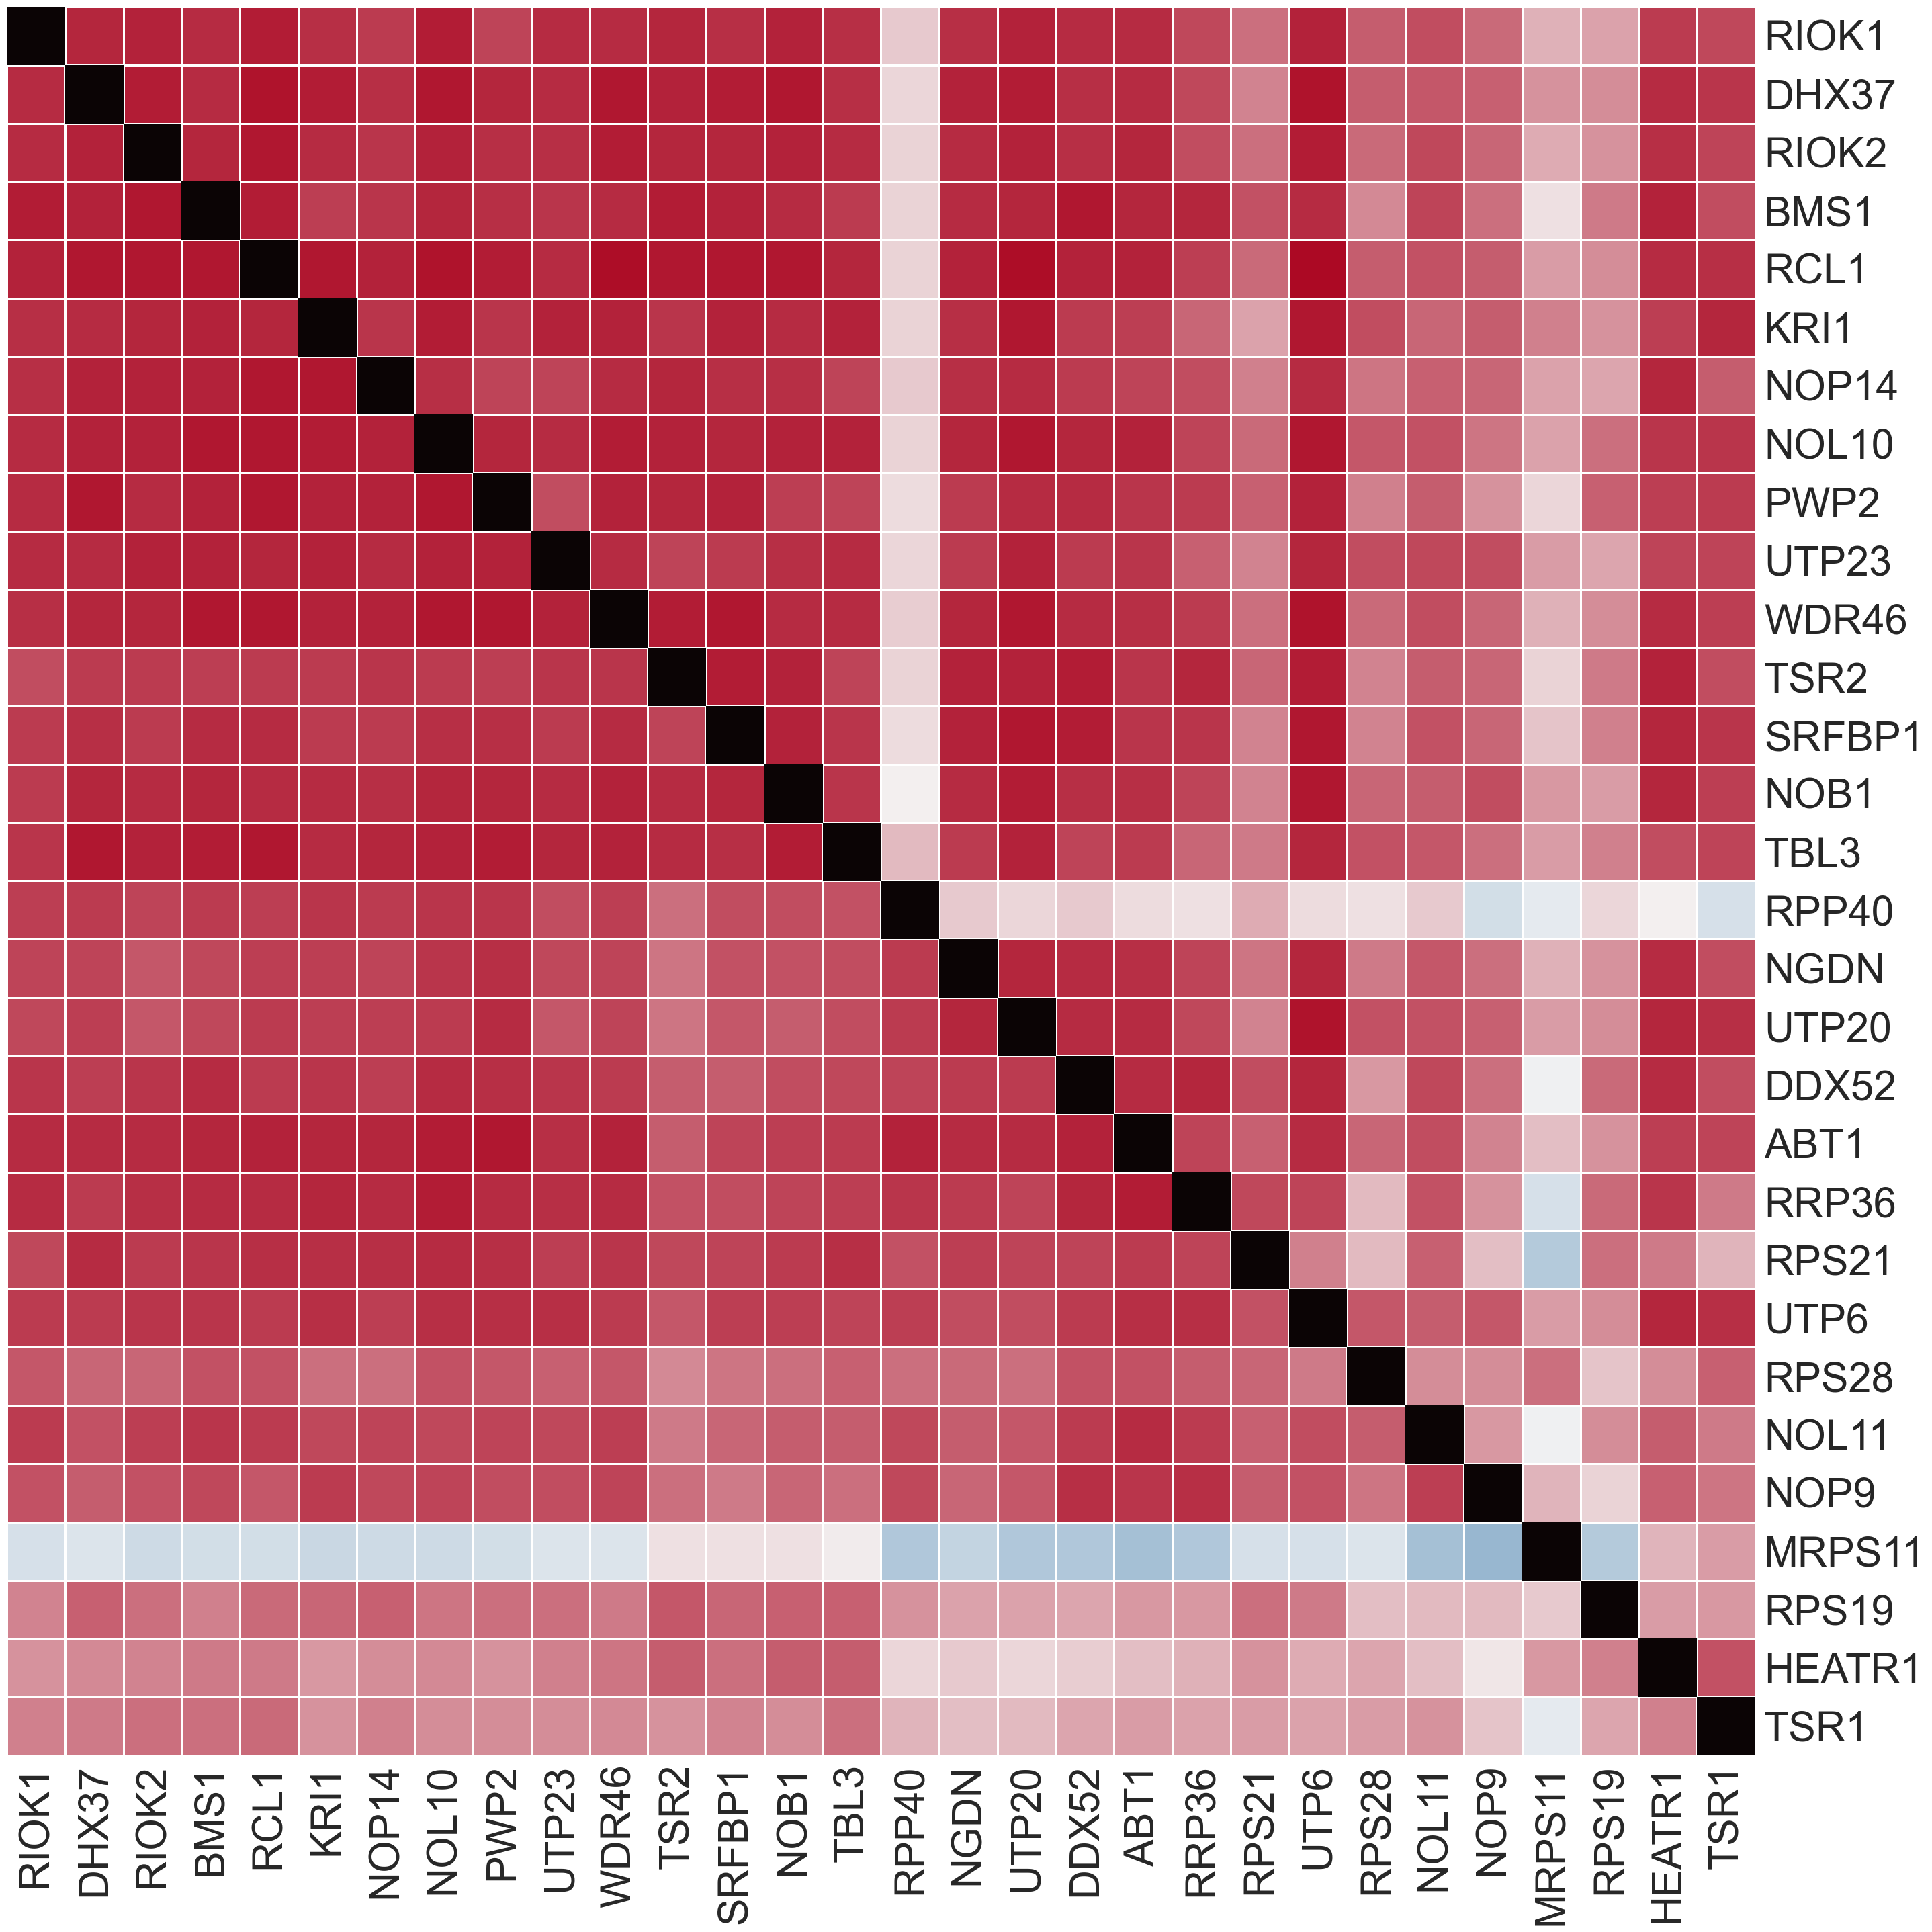

In [16]:
gene_set = 'MATURATION_OF_SSU_RRNA'
genes = gene_set_dict[gene_set]
genes = [i for i in genes if i in hit_list_DMEM]
coupled_heatmap(df_gene_pca_dict['DMEM'],df_gene_pca_dict['HPLM'],gene_set,genes,'DMEM_first_hits_only',4)

<Figure size 1000x1000 with 0 Axes>

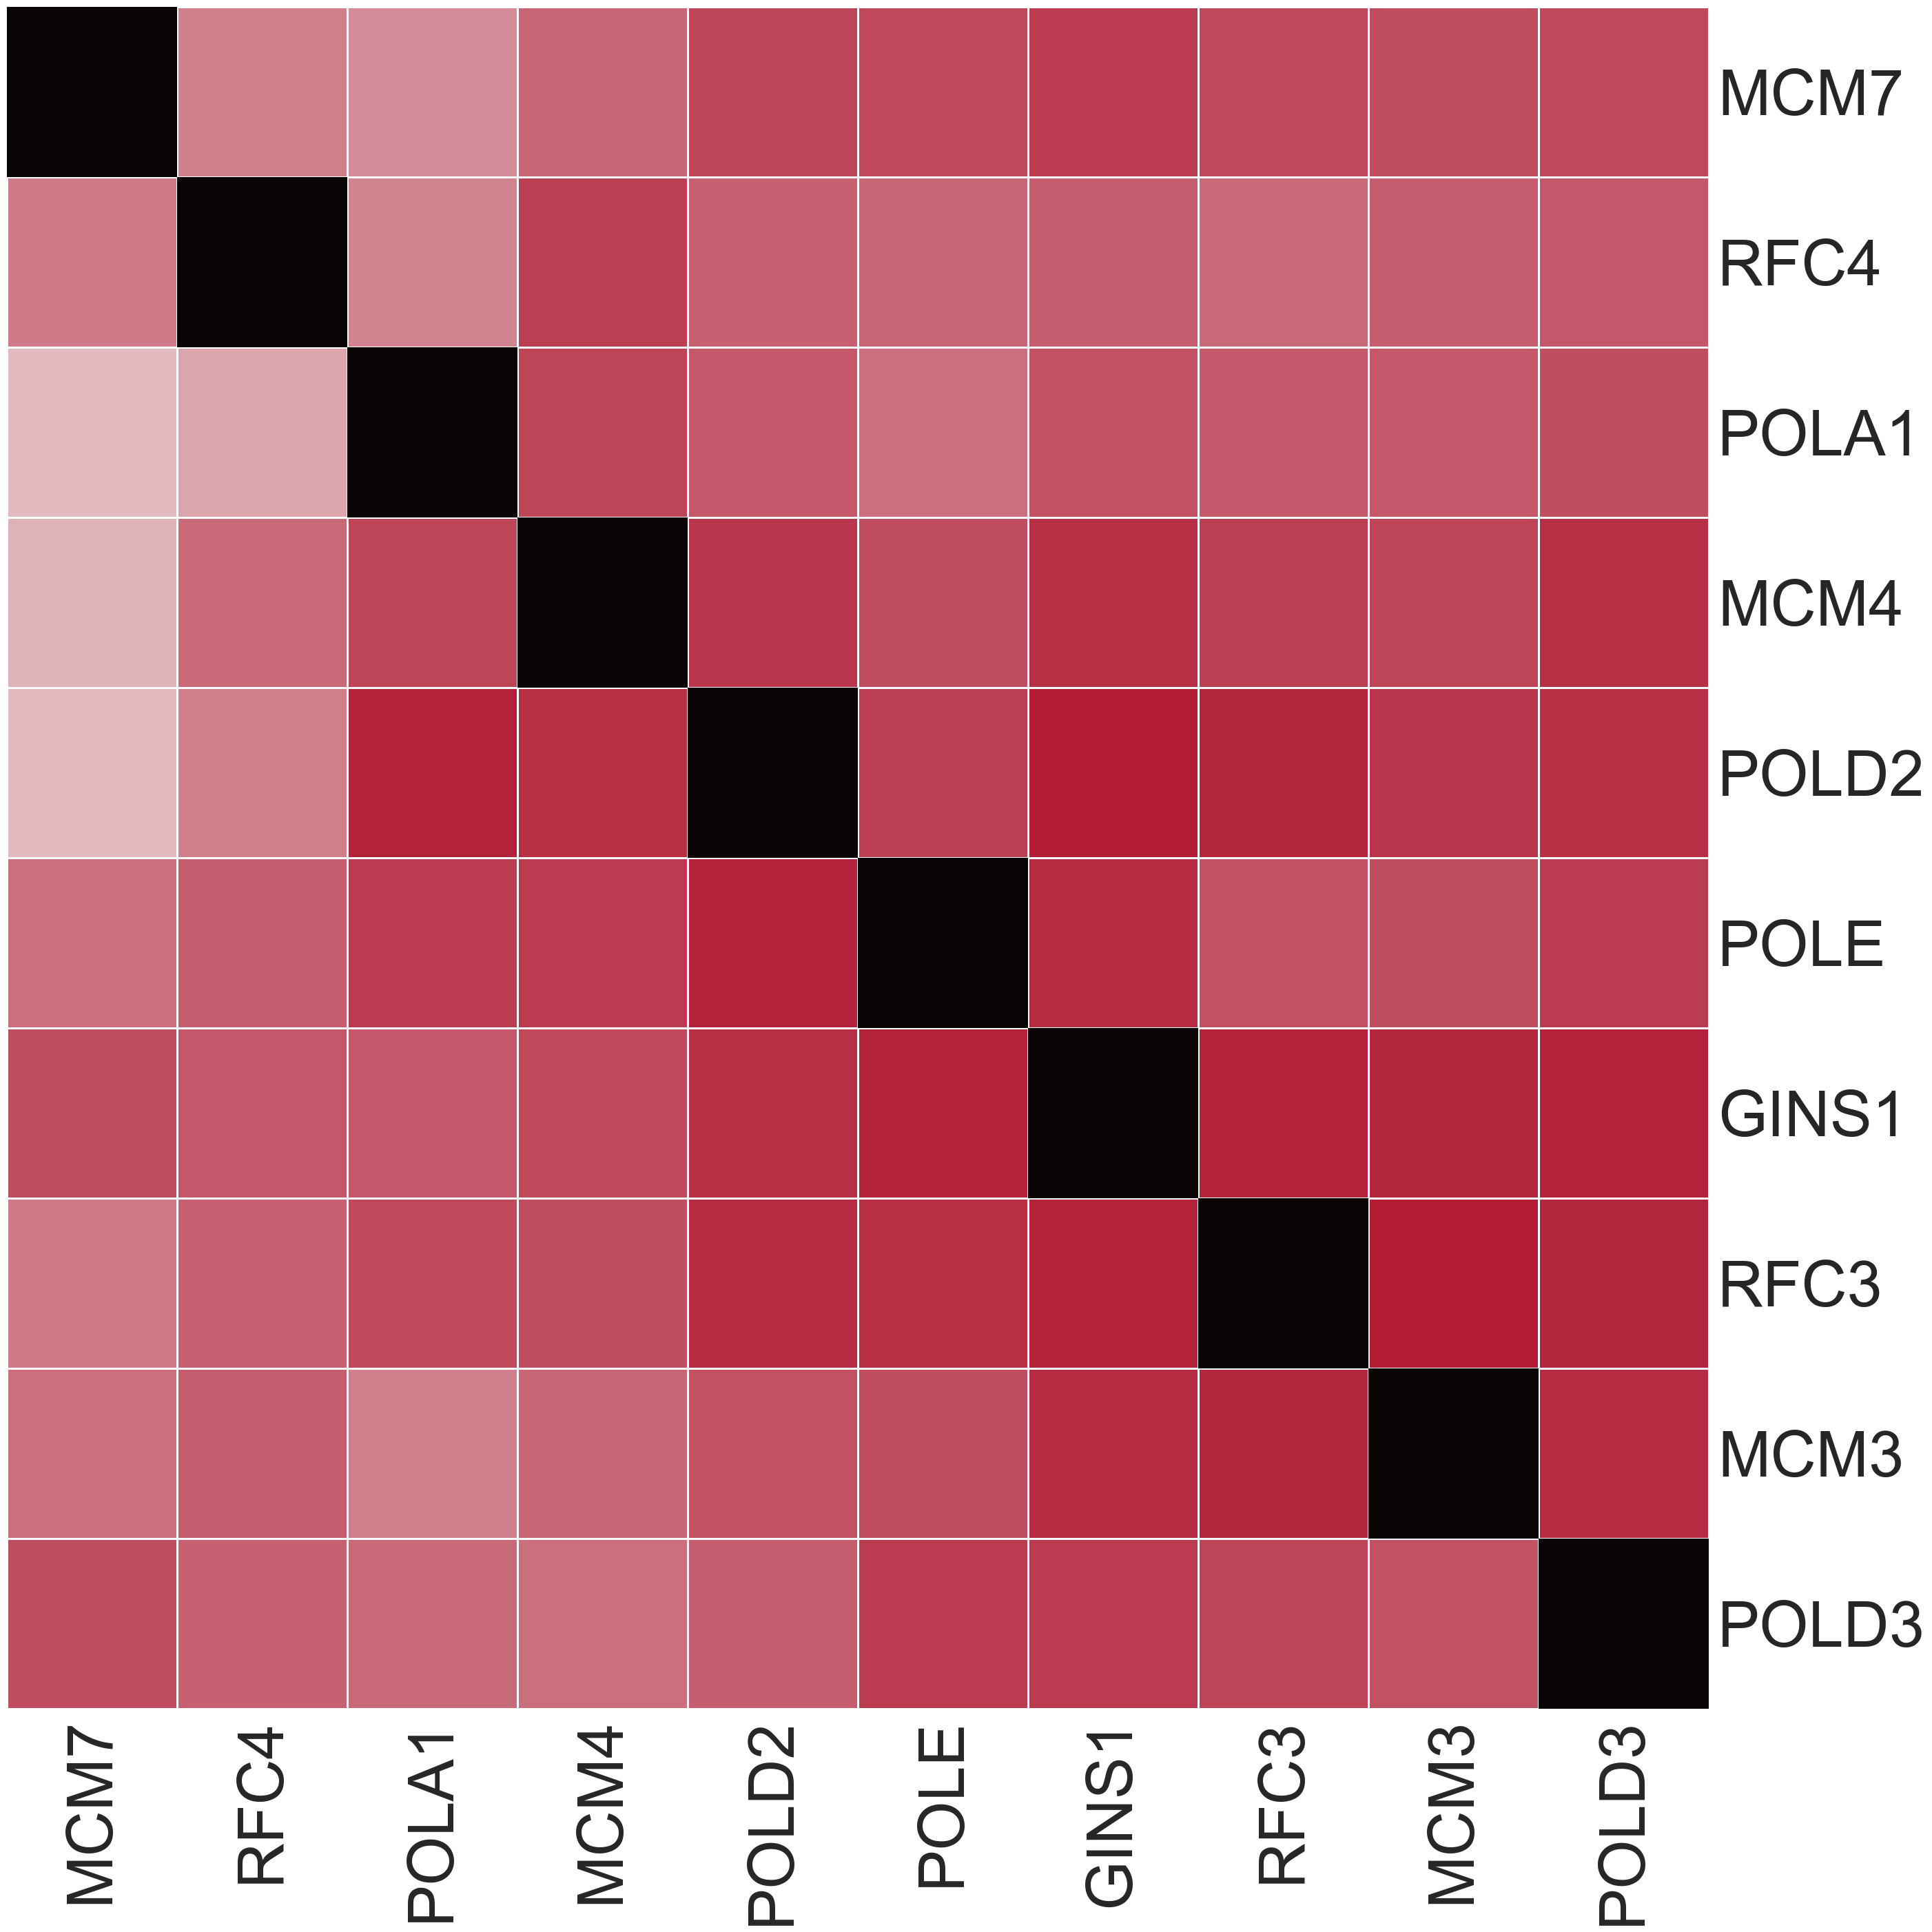

In [17]:
gene_set = 'DNA_STRAND_ELONGATION_INVOLVED_IN_DNA_REPLICATION'
genes = gene_set_dict[gene_set]
genes = [i for i in genes if i in hit_list_HPLM]
coupled_heatmap(df_gene_pca_dict['HPLM'],df_gene_pca_dict['DMEM'],gene_set,genes,'HPLM_first_hits_only',6)

<Figure size 1000x1000 with 0 Axes>

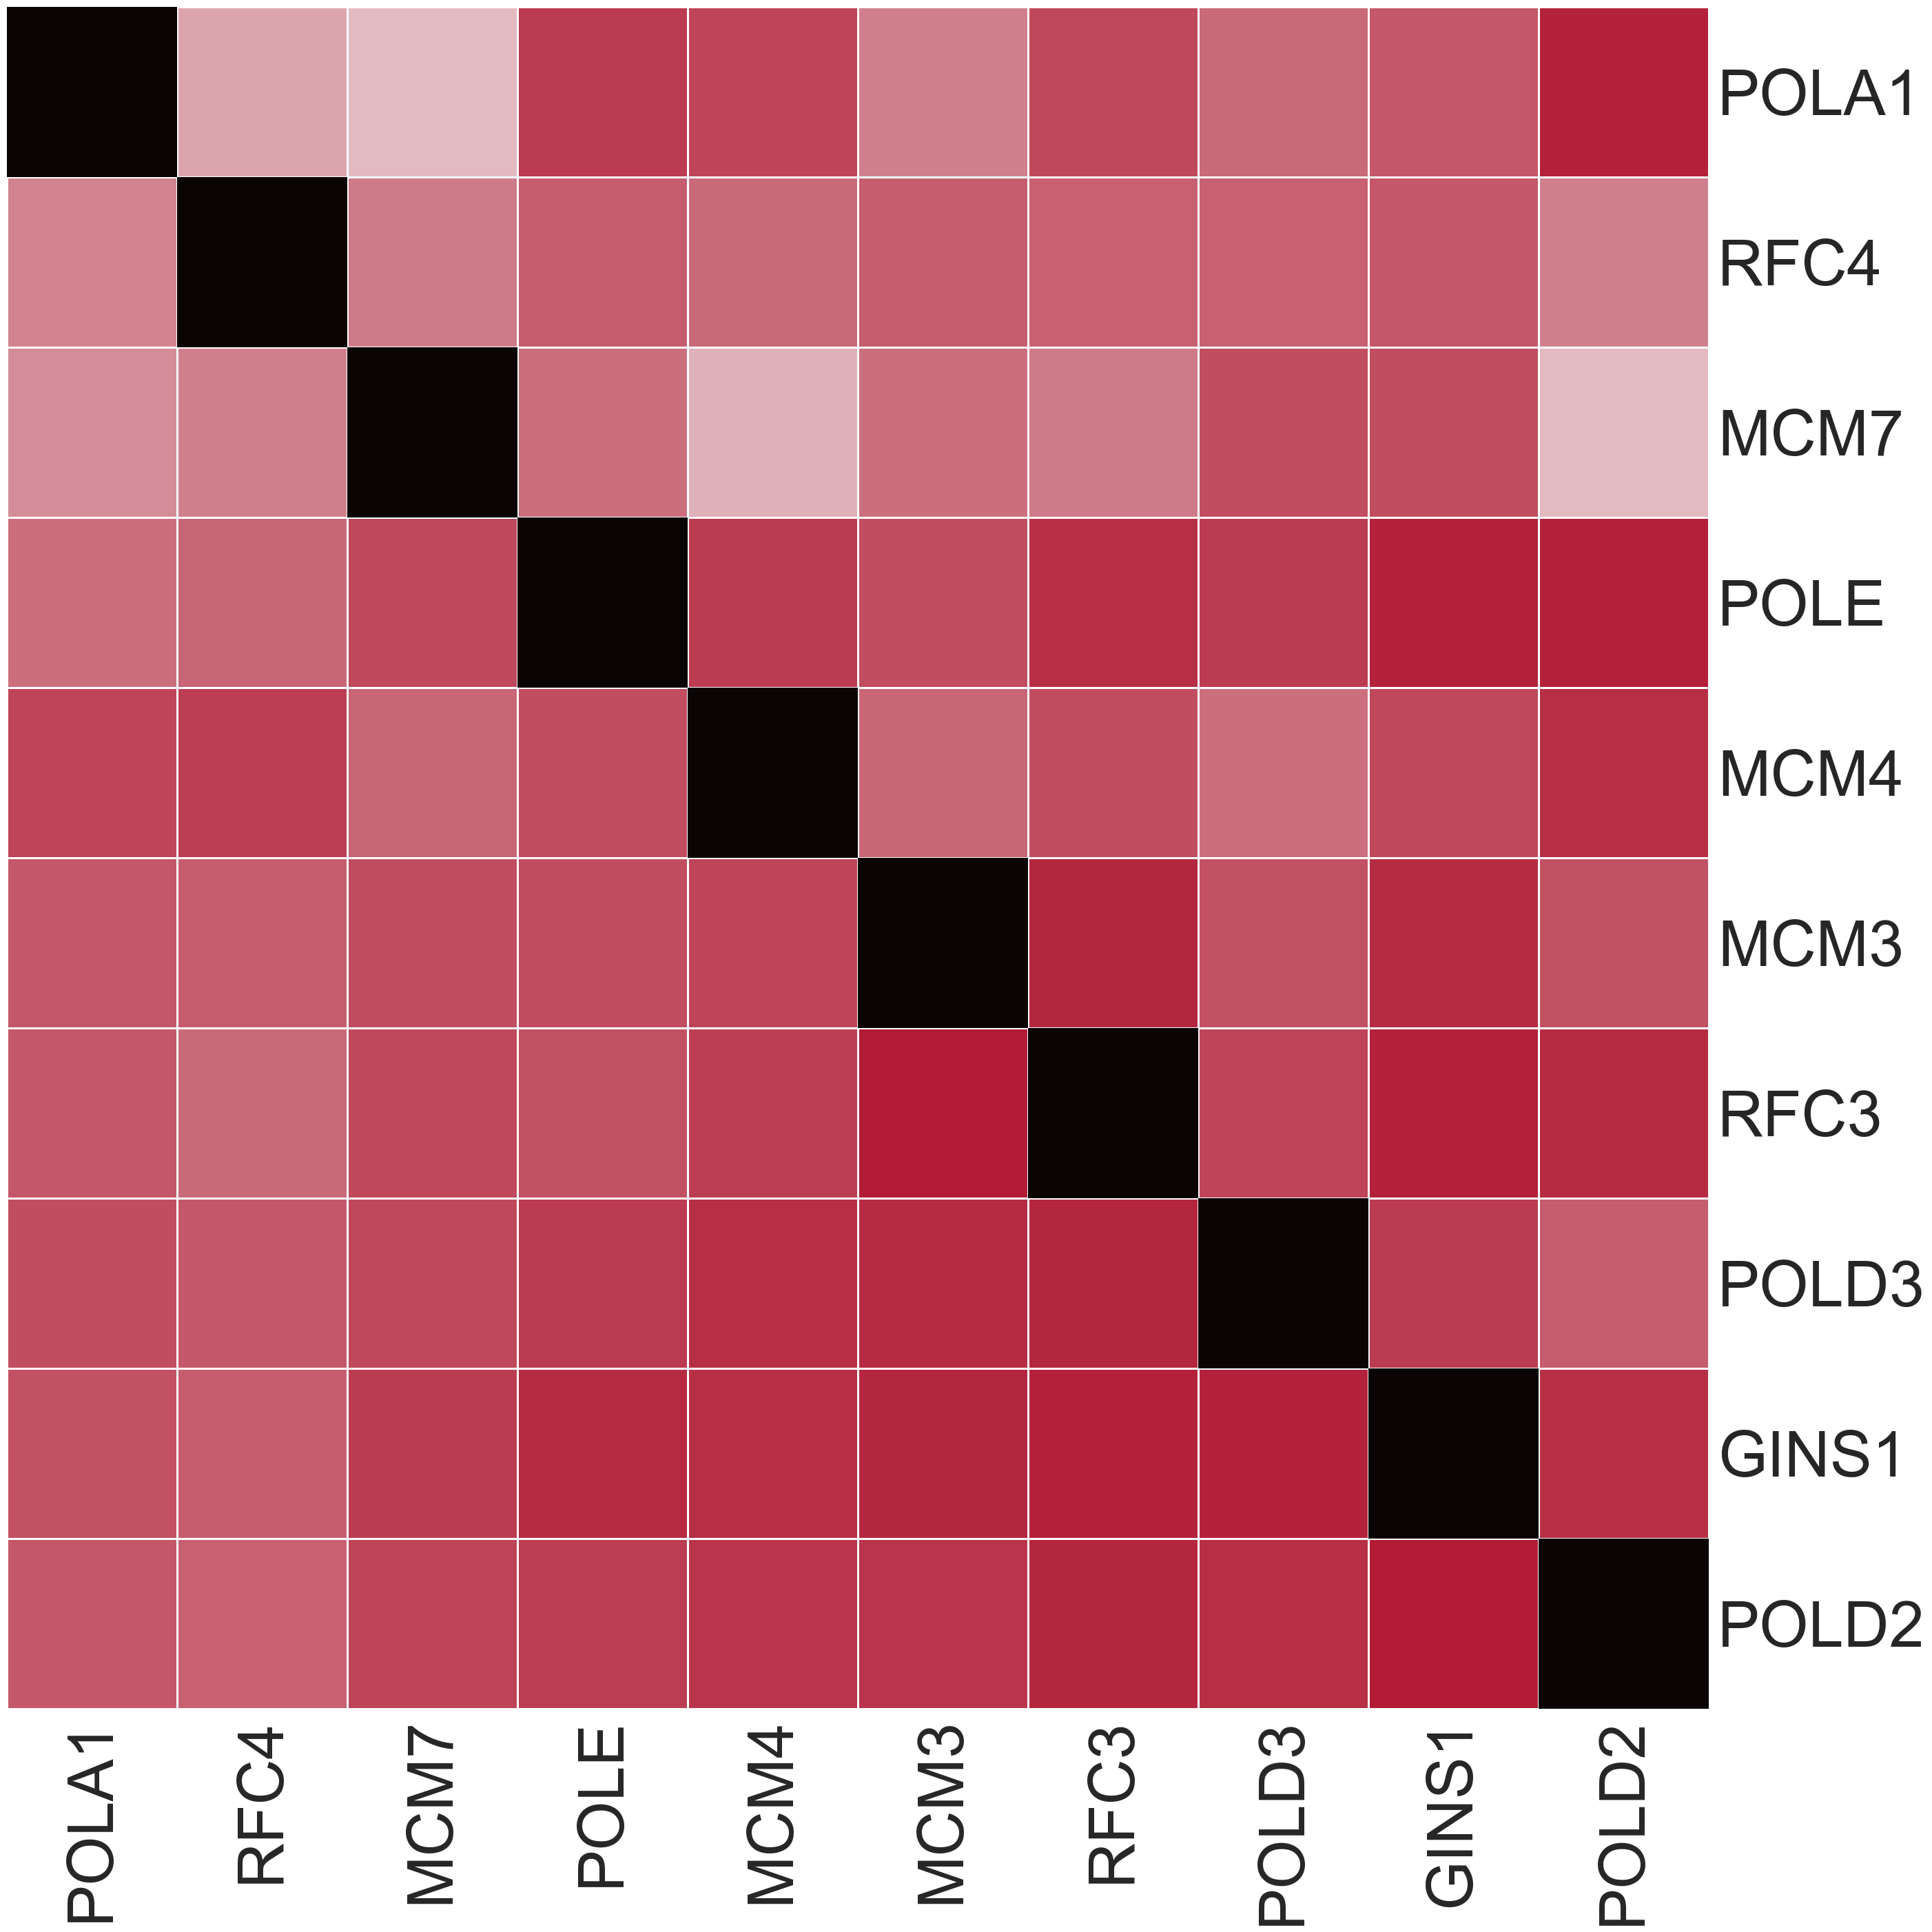

In [18]:
# Clustered based on the DMEM arm first
coupled_heatmap(df_gene_pca_dict['DMEM'],df_gene_pca_dict['HPLM'],gene_set,genes,'DMEM_first',6,alt_view=True)

<Figure size 1000x1000 with 0 Axes>

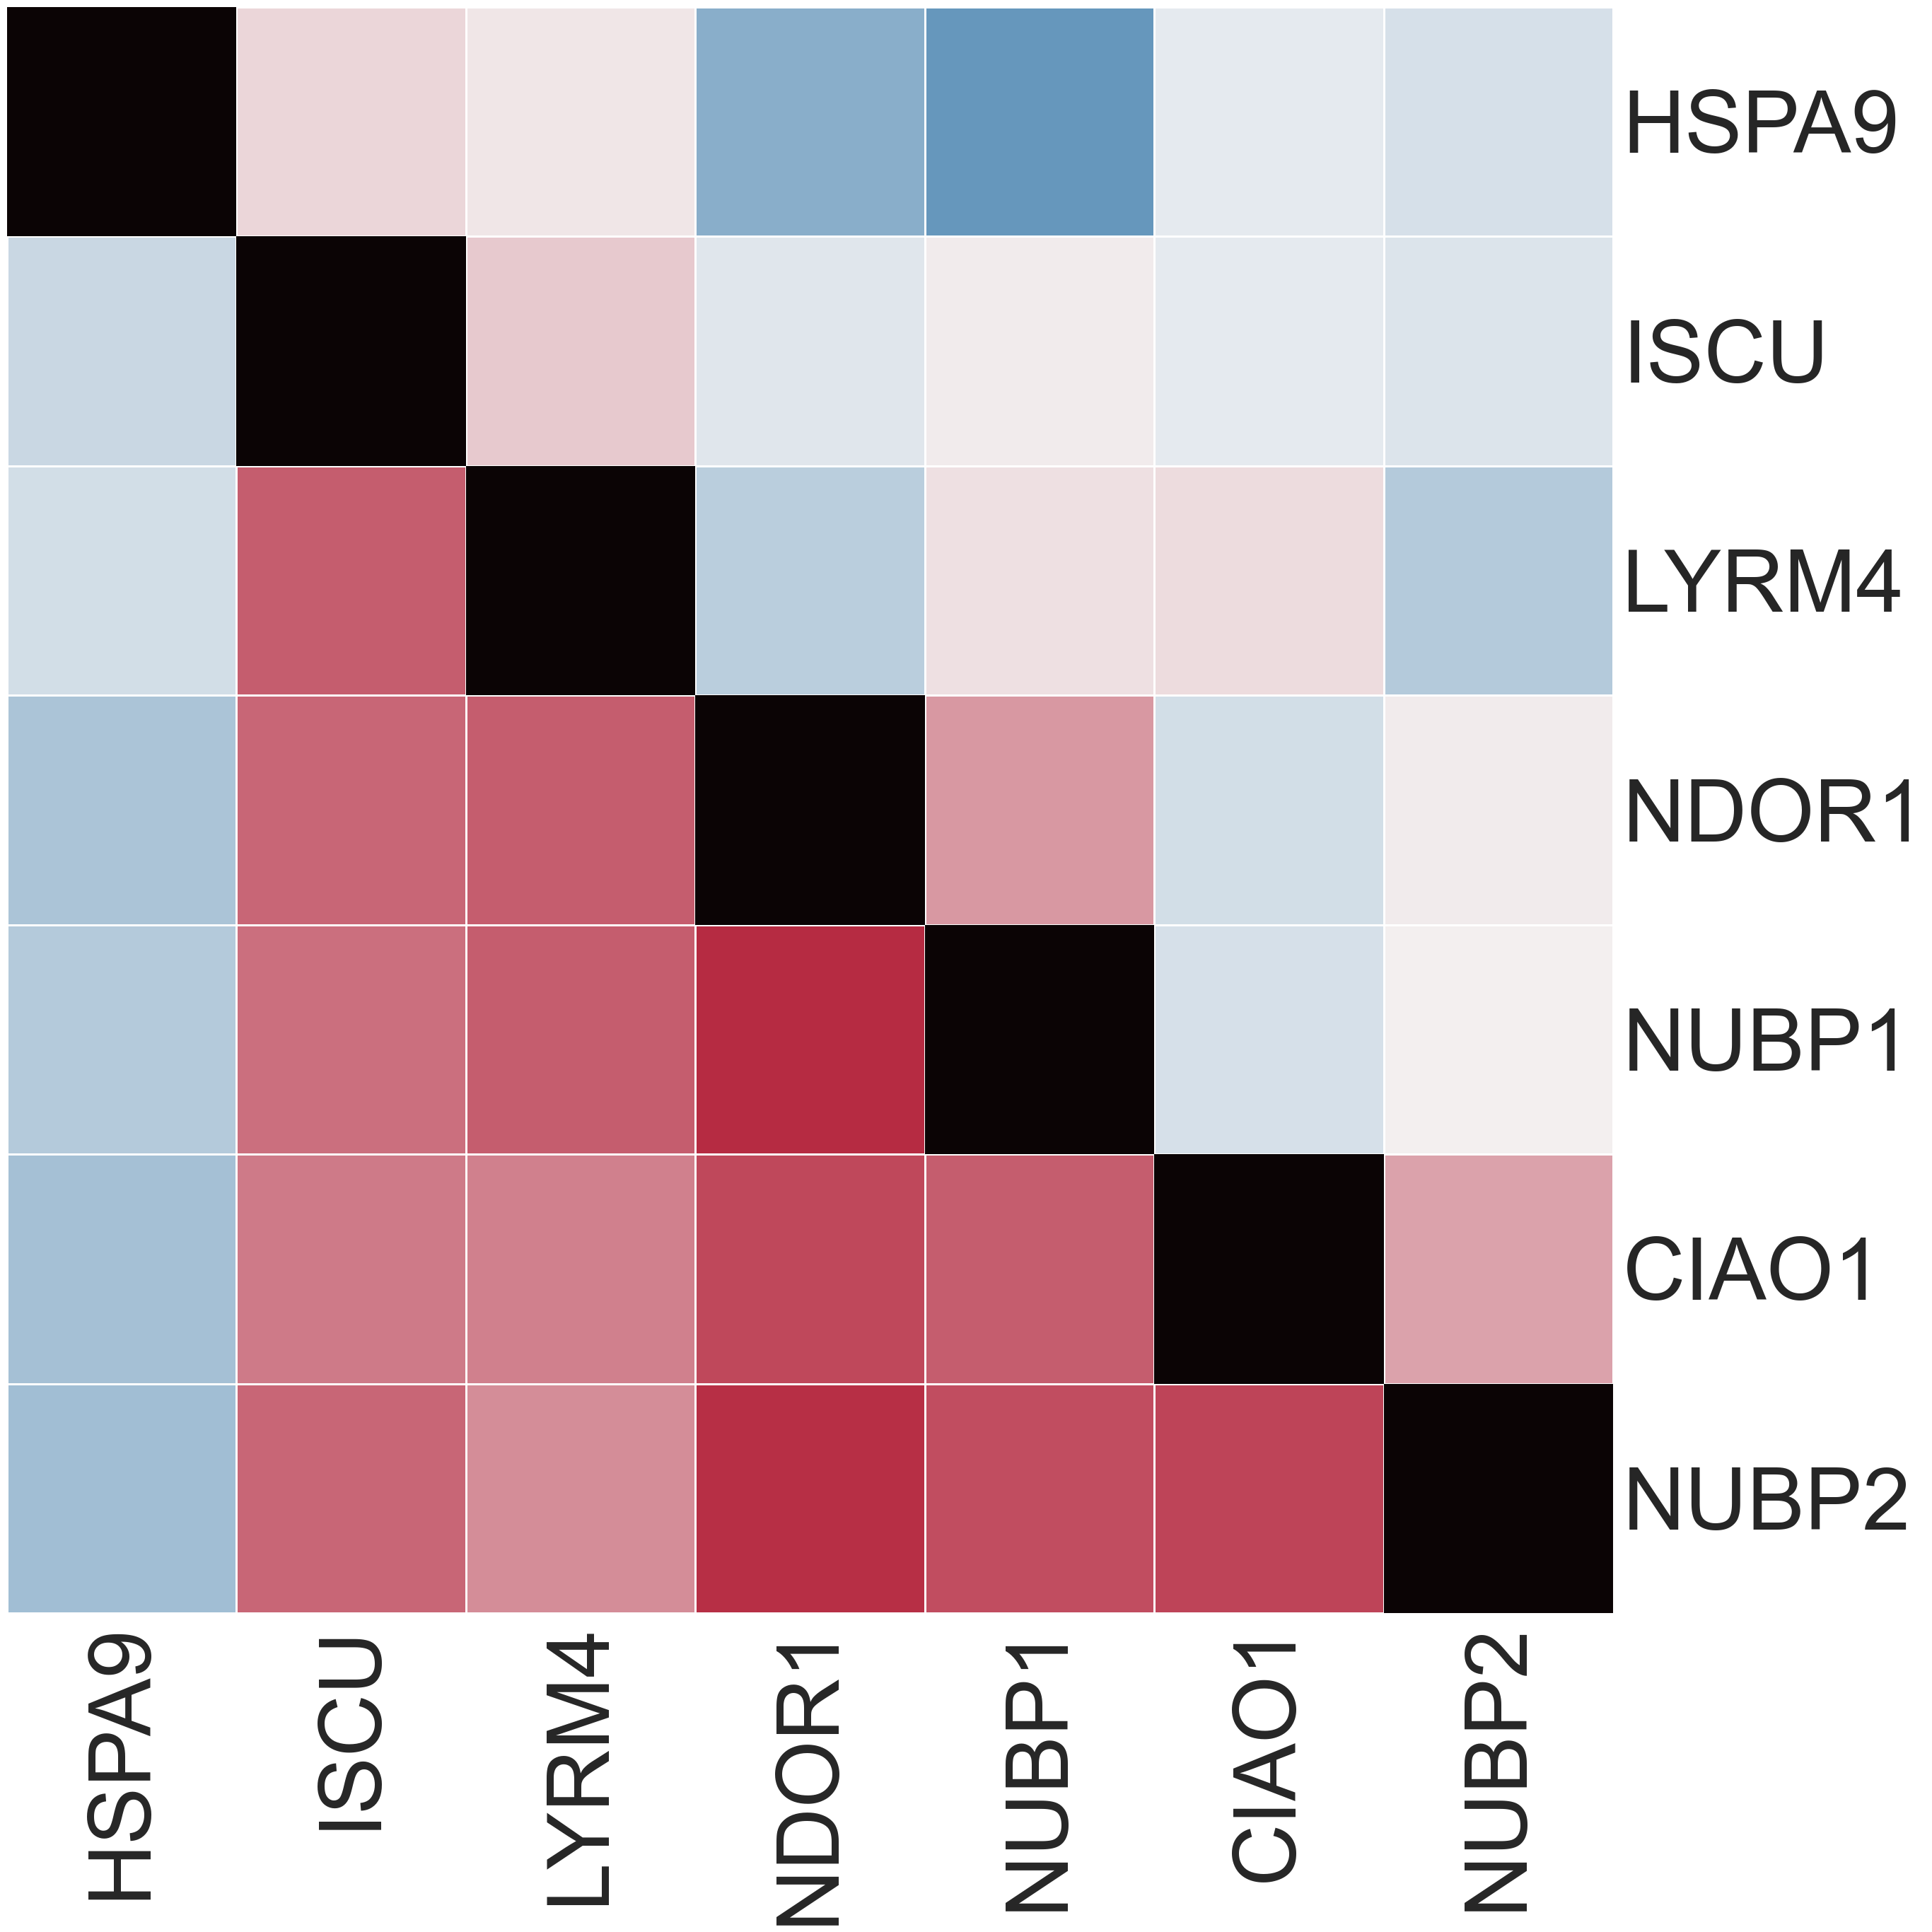

In [19]:
gene_set = 'IRON_SULFUR_CLUSTER_ASSEMBLY'
genes = gene_set_dict[gene_set]
genes = [i for i in genes if i in hit_list_DMEM]
coupled_heatmap(df_gene_pca_dict['DMEM'],df_gene_pca_dict['HPLM'],gene_set,genes,'DMEM_first_hits_only',8)

<Figure size 1000x1000 with 0 Axes>

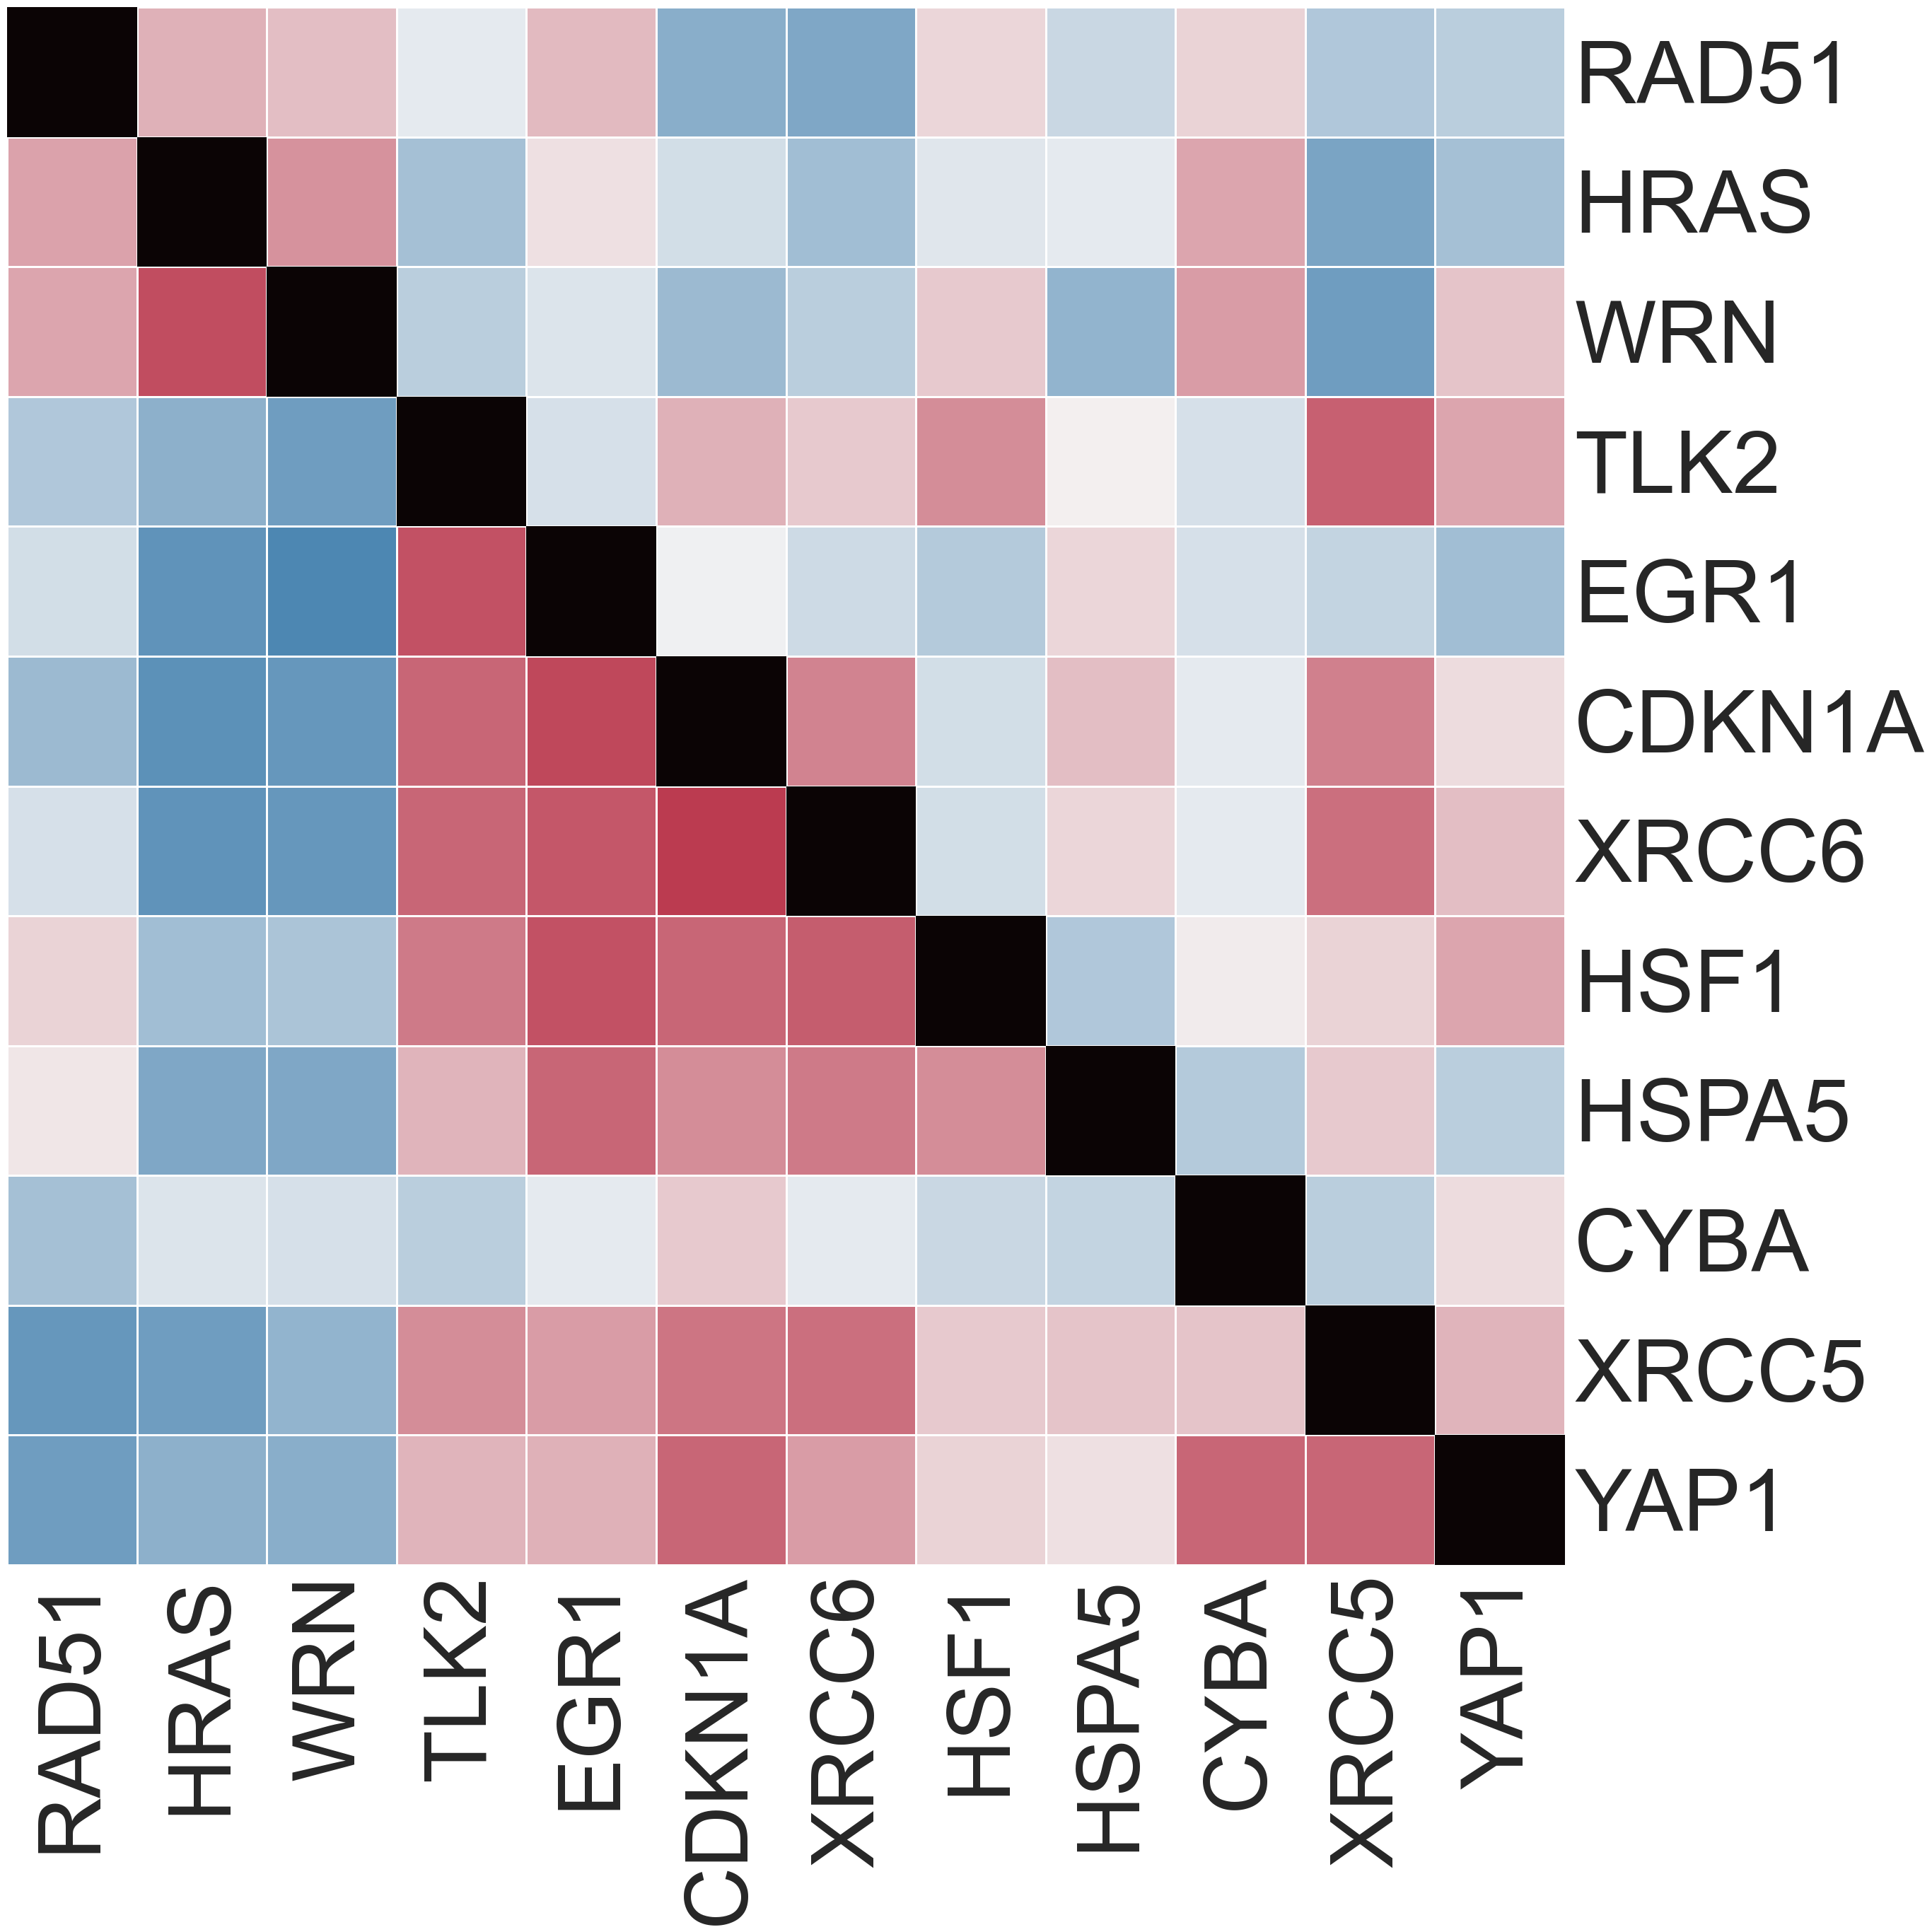

In [20]:
# Clustered based on the HPLM arm first
gene_set = 'CELLULAR_RESPONSE_TO_GAMMA_RADIATION'
genes = gene_set_dict[gene_set]
genes = [i for i in genes if i in hit_list_HPLM]
coupled_heatmap(df_gene_pca_dict['HPLM'],df_gene_pca_dict['DMEM'],gene_set,genes,'HPLM_first_hits_only',8)

# Figure 3J

In [27]:
# Load to bypass previous sections
whole_cell_hits_DMEM = pd.read_csv(os.path.join(output_folder,'HeLa_DMEM_plate_level_median_per_feat_sig_genes_1_FDR_whole_cell_hits.csv')).set_index('Gene')
comp_spec_hits_DMEM = pd.read_csv(os.path.join(output_folder,'HeLa_DMEM_plate_level_median_per_feat_sig_genes_1_FDR_compartment_specific_hits.csv')).set_index('Gene')
whole_cell_hits_HPLM = pd.read_csv(os.path.join(output_folder,'HeLa_DMEM_plate_level_median_per_feat_sig_genes_1_FDR_whole_cell_hits.csv')).set_index('Gene')
comp_spec_hits_HPLM = pd.read_csv(os.path.join(output_folder,'HeLa_DMEM_plate_level_median_per_feat_sig_genes_1_FDR_compartment_specific_hits.csv')).set_index('Gene')
df_sig_feature_expressed_DMEM = pd.read_csv(os.path.join(output_folder,f'HeLa_DMEM_significant_features_expressed_genes.csv')).set_index('Gene')
df_sig_feature_expressed_HPLM = pd.read_csv(os.path.join(output_folder,f'HeLa_HPLM_significant_features_expressed_genes.csv')).set_index('Gene')

In [28]:
hit_list_DMEM = list(comp_spec_hits_DMEM.index) + list(whole_cell_hits_DMEM.index)
df_hits_DMEM = df_gene_DMEM.loc[df_gene_DMEM.index.isin(hit_list_DMEM)]
hit_list_HPLM = list(comp_spec_hits_HPLM.index) + list(whole_cell_hits_HPLM.index)
df_hits_HPLM = df_gene_HPLM.loc[df_gene_HPLM.index.isin(hit_list_HPLM)]

In [29]:
# Function to calculate percentage of significant number of features from each channel
def df_maker(gene_group, df_genes, data):
    mito, cona, wga, dapi, phal = df_genes.Mito.mean(), df_genes.ConA.mean(), df_genes.WGA.mean(), df_genes.DAPI.mean(), df_genes.Phalloidin.mean()
    sum_all = df_genes.Sum.mean()
    data.loc[gene_group,'Mito'] = mito/sum_all*100
    data.loc[gene_group,'ConA'] = cona/sum_all*100
    data.loc[gene_group,'WGA'] = wga/sum_all*100
    data.loc[gene_group,'DAPI'] = dapi/sum_all*100
    data.loc[gene_group,'Phalloidin'] = phal/sum_all*100
    
    return data

In [30]:
# Organize the data into a dataframe
gene_groups = ['Vacuolar-type ATPase','Protein O-mannosylation','Outer Mitochondrial Membrane Protein Complex',
               'Cortical Cytoskeleton','DNA Polymerase Complex']
data_DMEM, data_HPLM = pd.DataFrame(index=gene_groups), pd.DataFrame(index=gene_groups)

for gene_group in gene_groups:
    gene_list = gene_set_dict[gene_group]
    gene_list = [gene for gene in gene_list if gene in hit_list_DMEM]
    df_genes_DMEM = df_sig_feature_expressed_DMEM.loc[gene_list]
    df_genes_DMEM = df_genes_DMEM.reset_index()
    data_DMEM = df_maker(gene_group, df_genes_DMEM, data_DMEM)
    
for gene_group in gene_groups:
    gene_list = gene_set_dict[gene_group]
    gene_list = [gene for gene in gene_list if gene in hit_list_HPLM]
    df_genes_HPLM = df_sig_feature_expressed_HPLM.loc[gene_list]
    df_genes_HPLM = df_genes_HPLM.reset_index()
    data_HPLM = df_maker(gene_group, df_genes_HPLM, data_HPLM)

HeLa DMEM Vacuolar-type ATPase


<Figure size 640x480 with 0 Axes>

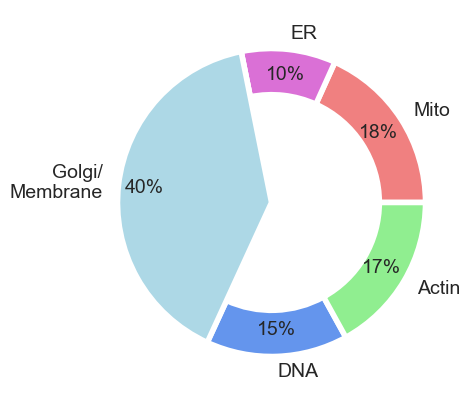

HeLa DMEM Protein O-mannosylation


<Figure size 640x480 with 0 Axes>

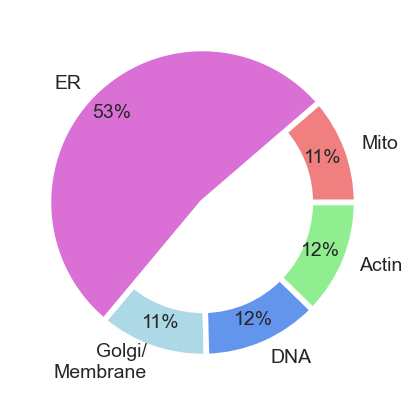

HeLa DMEM Outer Mitochondrial Membrane Protein Complex


<Figure size 640x480 with 0 Axes>

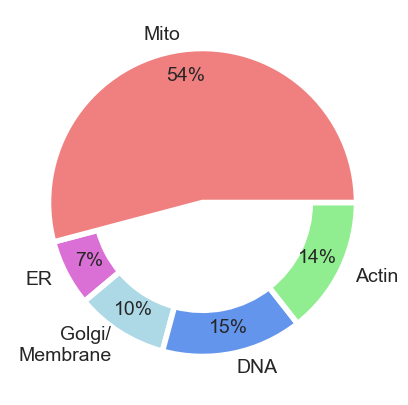

HeLa DMEM Cortical Cytoskeleton


<Figure size 640x480 with 0 Axes>

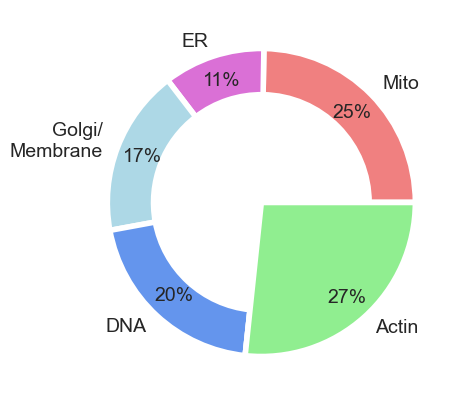

HeLa DMEM DNA Polymerase Complex


<Figure size 640x480 with 0 Axes>

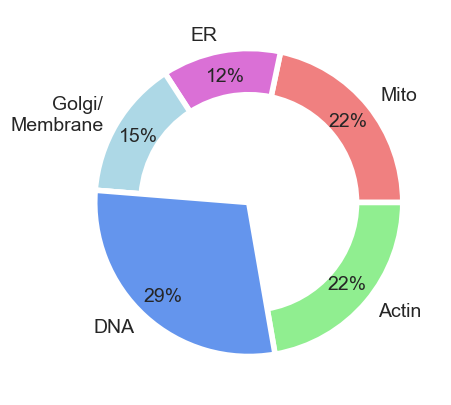

HeLa HPLM Vacuolar-type ATPase


<Figure size 640x480 with 0 Axes>

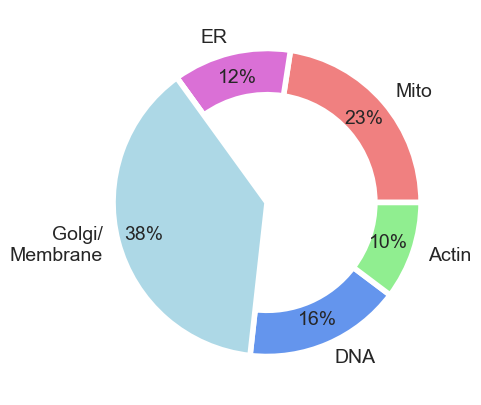

HeLa HPLM Protein O-mannosylation


<Figure size 640x480 with 0 Axes>

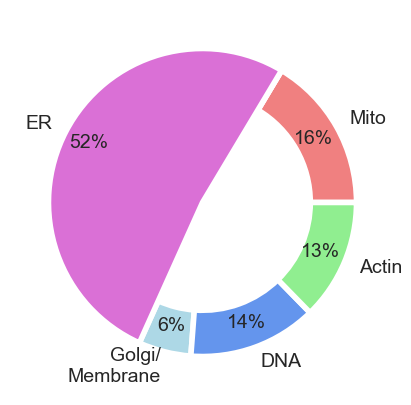

HeLa HPLM Outer Mitochondrial Membrane Protein Complex


<Figure size 640x480 with 0 Axes>

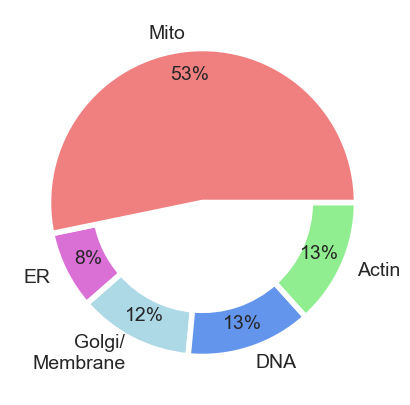

HeLa HPLM Cortical Cytoskeleton


<Figure size 640x480 with 0 Axes>

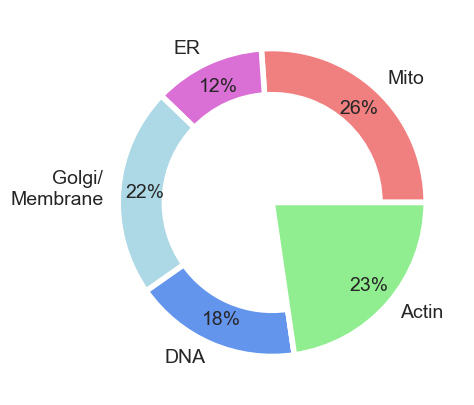

HeLa HPLM DNA Polymerase Complex


<Figure size 640x480 with 0 Axes>

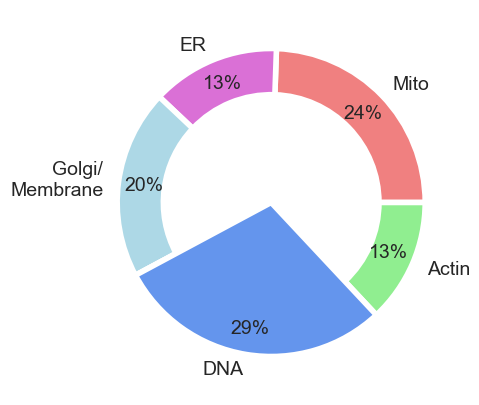

In [122]:
# Plot fraction of features per compartments for Fig 3J
color_dict = {'Mito':'lightcoral','ER':'orchid', 'Golgi/\nMembrane':'lightblue', 'DNA':'cornflowerblue','Actin':'lightgreen'}
place_dict = {'Vacuolar-type ATPase':2,
 'Protein O-mannosylation':1,
 'Outer Mitochondrial Membrane Protein Complex':0,
 'Cortical Cytoskeleton':4,
 'DNA Polymerase Complex':3}
for group in list(data_DMEM.index):
        print('HeLa DMEM', group)
        group_name = group.replace(' ','_')
        size = data_DMEM.loc[group].values

        plt.clf()
        fig, ax = plt.subplots(figsize=(5, 5))

        # Custom wedges
        ax.pie(size, 
                labels=color_dict.keys(), 
                wedgeprops = {'width':.3, 'linewidth':4, 'edgecolor':'white'},
                colors = color_dict.values(),
                autopct='%1.0f%%', 
                pctdistance=0.83,
                textprops={'fontsize': 14})
        g = ax.pie(size,
                wedgeprops = {'width':1, 'linewidth' : 4, 'edgecolor' : 'white','alpha':0},
                colors = color_dict.values(),
                )
        g[0][place_dict[group]].set_alpha(1.0)
        plt.savefig(os.path.join(output_folder,'figure_panels',f'Fig3J_HeLa_DMEM_fraction_features_per_compartments_{group_name}.png'), 
                        dpi=300,
                        facecolor='w', 
                        edgecolor='w',
                        bbox_inches='tight')
        plt.show()

# Plot fraction of features per compartments for Fig 3J
for group in list(data_HPLM.index):
        print('HeLa HPLM', group)
        group_name = group.replace(' ','_')
        size = data_HPLM.loc[group].values

        plt.clf()
        fig, ax = plt.subplots(figsize=(5, 5))

        # Custom wedges
        ax.pie(size, 
                labels=color_dict.keys(), 
                wedgeprops = {'width':.3, 'linewidth':4, 'edgecolor':'white'},
                colors = color_dict.values(),
                autopct='%1.0f%%', 
                pctdistance=0.83,
                textprops={'fontsize': 14})
        g = ax.pie(size,
                wedgeprops = {'width':1, 'linewidth' : 4, 'edgecolor' : 'white','alpha':0},
                colors = color_dict.values(),
                )
        g[0][place_dict[group]].set_alpha(1.0)
        plt.savefig(os.path.join(output_folder,'figure_panels',f'Fig3J_HeLa_HPLM_fraction_features_per_compartments_{group_name}.png'), 
                        dpi=300,
                        facecolor='w', 
                        edgecolor='w',
                        bbox_inches='tight')
        plt.show()


# Figure 3K

In [24]:
# Calculate the morphological signal scores for each perturbation and sort 
def morphological_signal_scores(df_p_values,expressed_gene_list):
    exp_p_values = df_p_values.loc[expressed_gene_list[:-1]]
    p_values_neg_log = -np.log10(exp_p_values)
    ranked_list = pd.DataFrame(((exp_p_values <= 0.001) * p_values_neg_log).sum(axis=1).sort_values(ascending=False))
    # Update problematic gene names
    rename_dic = {"SEPT1":"SEPTIN1","SEPT2":"SEPTIN2","SEPT3":"SEPTIN3","SEPT4":"SEPTIN4","SEPT5":"SEPTIN5",
             "SEPT6":"SEPTIN6","SEPT7":"SEPTIN7","SEPT8":"SEPTIN8","SEPT9":"SEPTIN9","SEPT10":"SEPTIN10",
             "SEPT11":"SEPTIN11","SEPT12":"SEPTIN12","SEPT14":"SEPTIN15","SEP15":"SELENOF",
             "MARCH1":"MARCHF1","MARCH2":"MARCHF2","MARCH3":"MARCHF3","MARCH4":"MARCHF4","MARCH5":"MARCHF5",
             "MARCH6":"MARCHF6","MARCH7":"MARCHF7","MARCH8":"MARCHF8","MARCH9":"MARCHF9","MARCH10":"MARCHF10",
             "MARCH11":"MARCHF11"}
    ranked_list = ranked_list.rename(index = rename_dic)
    return ranked_list

HeLa_DMEM_ranked_list = morphological_signal_scores(df_p_values_DMEM, expressed_gene_list)
HeLa_HPLM_ranked_list = morphological_signal_scores(df_p_values_HPLM, expressed_gene_list)

HeLa_DMEM_ranked_list.head()

,0
Gene,
MED12,3505.619834
ARPC4,3159.619834
PGGT1B,3092.080485
ARPC2,2994.974043
TRRAP,2966.084552


In [25]:
# Load the HeLa DEMETER model gene effect data
HeLa_gene_effect = pd.read_csv('../Supplemental_4/inputs/D2_combined_gene_dep_scores_HeLa.csv')

# Merge the morphological signal scores and the CRISPR gene effect data into a single dataframe
HeLa_DMEM_effect_score_df = HeLa_gene_effect.merge(HeLa_DMEM_ranked_list,on='Gene').rename(columns={0:'Score','BayesFactor':'Effect'})
HeLa_DMEM_effect_score_df['Effect'] = pd.to_numeric(HeLa_DMEM_effect_score_df['Effect'],errors = 'coerce')

# Merge the morphological signal scores and the CRISPR gene effect data into a single dataframe
HeLa_HPLM_effect_score_df = HeLa_gene_effect.merge(HeLa_HPLM_ranked_list,on='Gene').rename(columns={0:'Score','BayesFactor':'Effect'})
HeLa_HPLM_effect_score_df['Effect'] = pd.to_numeric(HeLa_HPLM_effect_score_df['Effect'],errors = 'coerce')

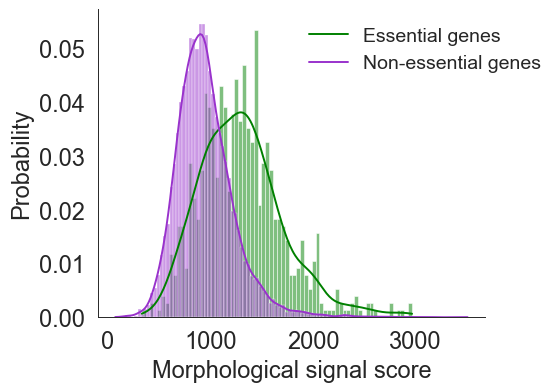

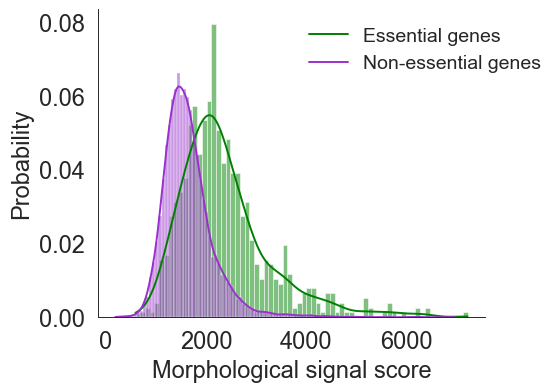

In [26]:
def essential_score_plotter(effect_score_df, data_set,t = -0.5):
    # Plot HeLa morphological signal score for the essential genes
    sns.set_theme(style="white",rc = {'axes.linewidth': 0.7,'xtick.labelsize':17,'ytick.labelsize':17})
    fig, ax = plt.subplots(figsize=(5,4))
    
    # Threshold for essential genes
    essential_genes = effect_score_df.query(f'Effect < {t}').Score
    non_essential_genes = effect_score_df.query(f'Effect >= {t}').Score
    
    sns.histplot(essential_genes ,color='green' ,stat= 'probability' ,bins= 70, kde=True, line_kws={'lw':1.4} , alpha=0.5,ax = ax);
    sns.histplot(non_essential_genes ,color='darkorchid' ,stat= 'probability' ,bins= 110, kde=True, line_kws={'lw':1.4} ,alpha=0.5,ax = ax);
    
    ax.set_ylabel('Probability',size=17)
    ax.set_xlabel('Morphological signal score',size=17)
    font = font_manager.FontProperties(size=14)
    ax.legend(['Essential genes','Non-essential genes'],loc='upper left', bbox_to_anchor=(0.5,1),frameon=False,prop=font )
    sns.despine(top = True)
    
    fig.savefig(os.path.join(output_folder,'figure_panels',f'Fig3K_HeLa_{data_set}_Morphological_signal_score_essential_genes.png'), dpi=300,facecolor='w', edgecolor='w', bbox_inches='tight')
    plt.show()
    
essential_score_plotter(HeLa_DMEM_effect_score_df,'DMEM')
essential_score_plotter(HeLa_HPLM_effect_score_df,'HPLM')
